In [1]:
# import config
from config_ML import *

# import basic modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set options
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

# preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from helper_functions_ML import *


# classifiers
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score, roc_auc_score

# TODO: change fill_missing_vals() so that original feat_train df will not get filled!!!!


In [2]:
# config for SVM
feature_groups_selected = ['gnomad', 'cellxgene', 'descartes', 'gtex', 'mgi', 'paralogues', 'phasCons', 'CpG_o2e']
omit_scaling_features = ['paralogues', 'mgi']

In [3]:
# load training data
feat_train = pd.read_csv(f'{train_test_data_dir}/feat_train_{data_prep_date}.csv')
labels_train = pd.read_csv(f'{train_test_data_dir}/labels_train_{data_prep_date}.csv')

In [4]:
# get selected features
features_selected = get_features_from_groups(feature_groups_selected, feat_train)
feat_train = feat_train[['hgnc_id_int'] + features_selected]

In [5]:
# fill features missing values
feat_train_filled = fill_missing_vals(feat_train, "SVM")

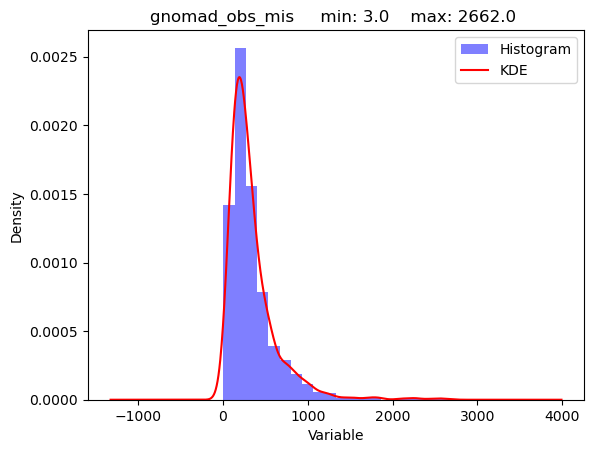

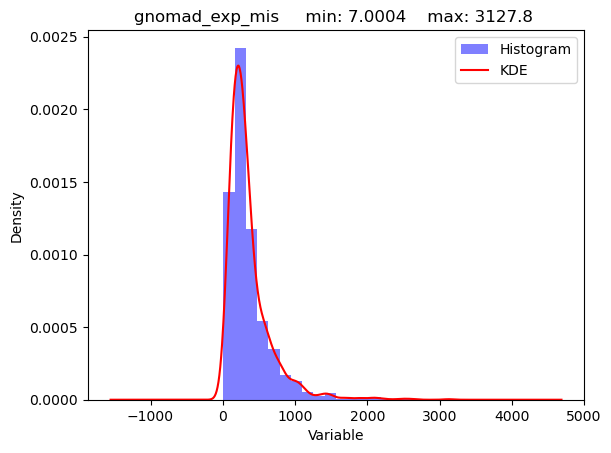

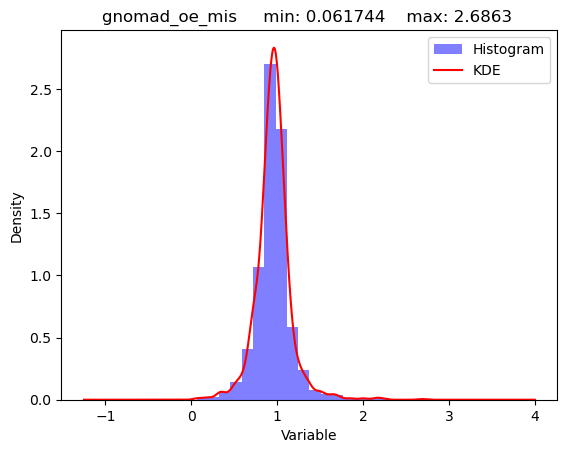

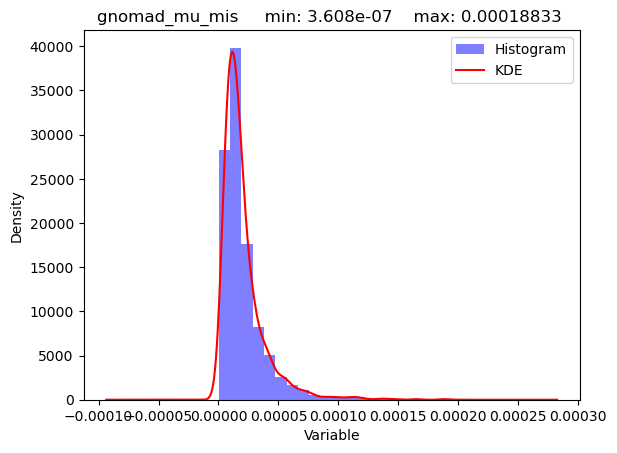

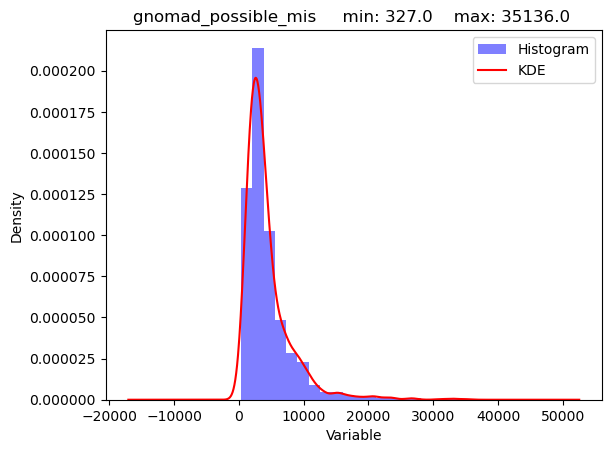

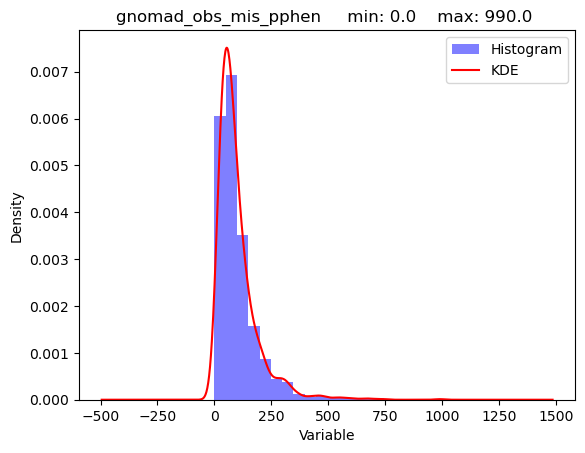

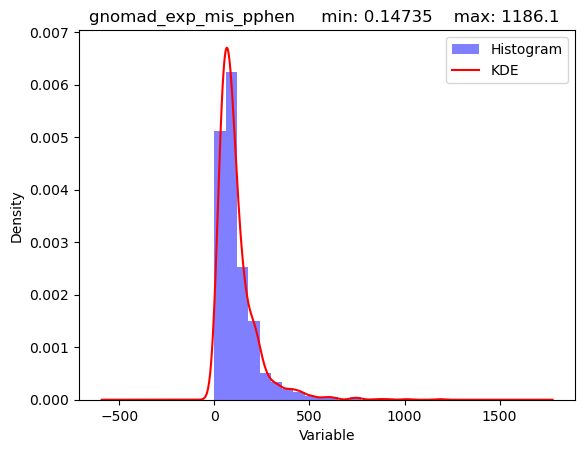

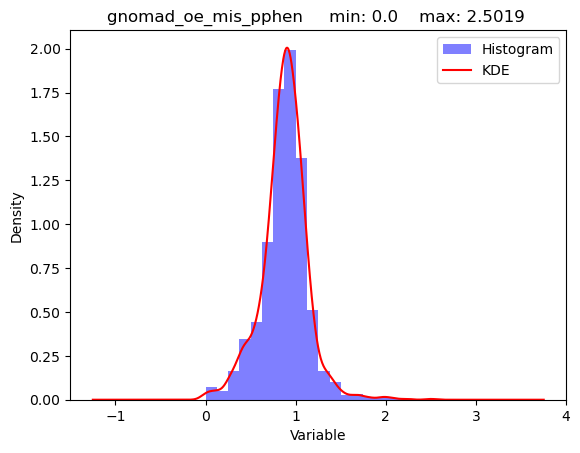

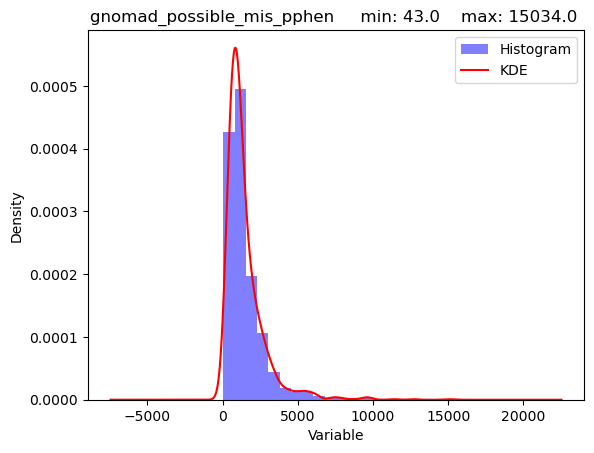

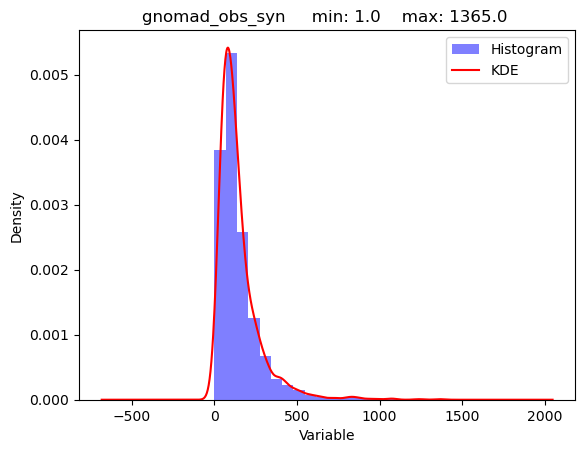

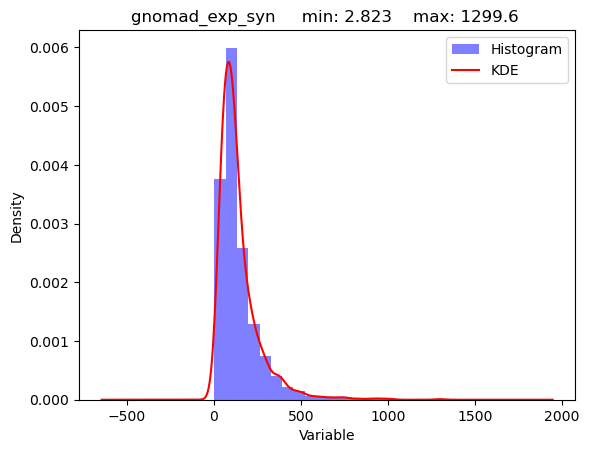

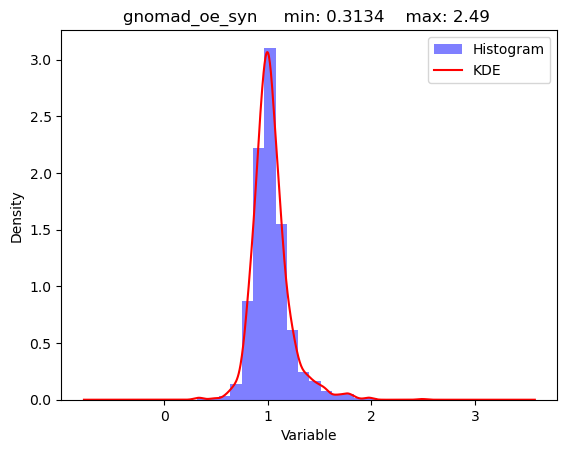

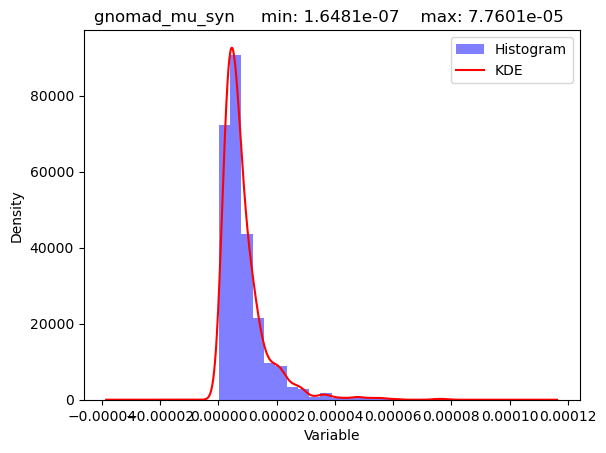

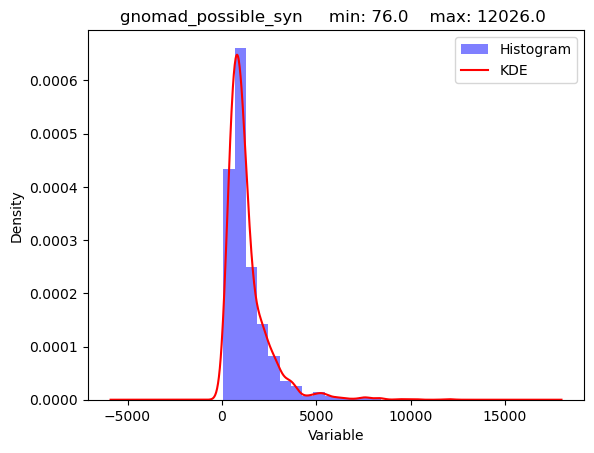

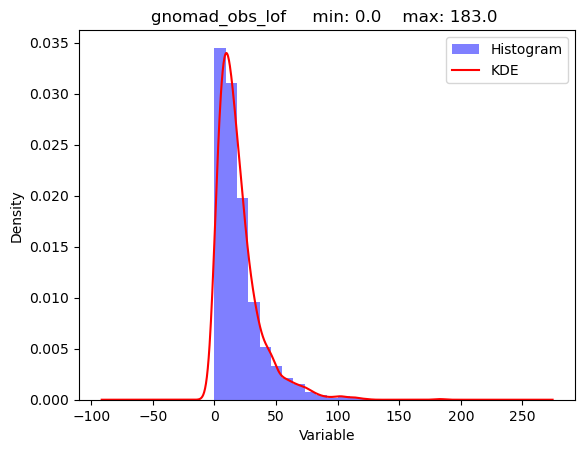

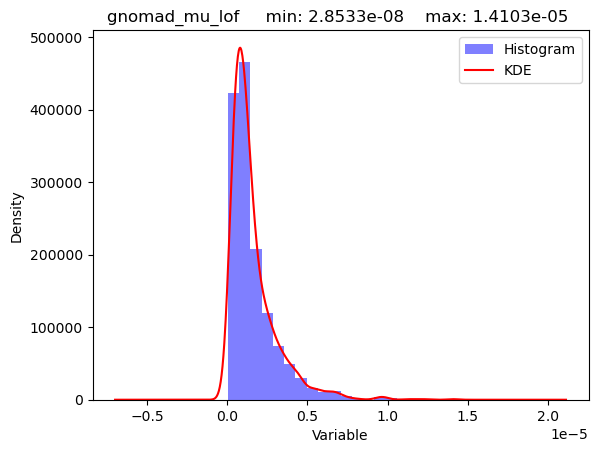

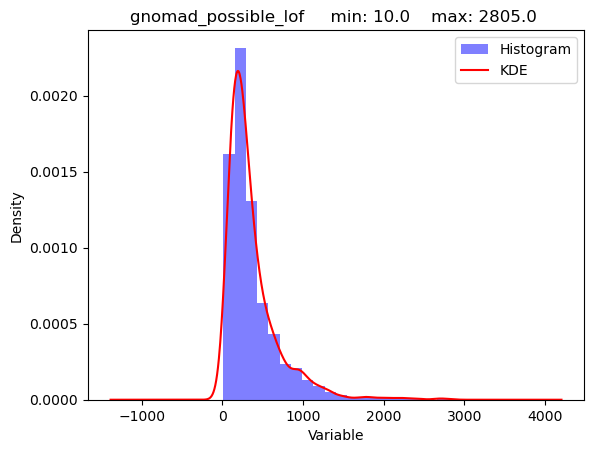

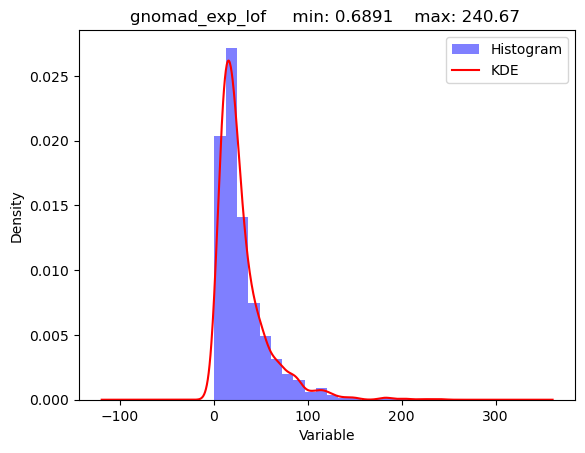

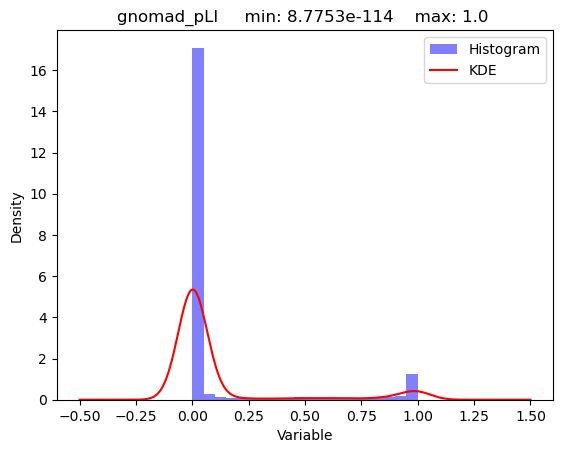

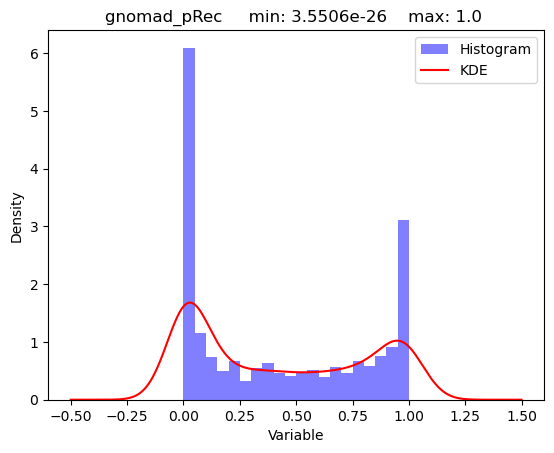

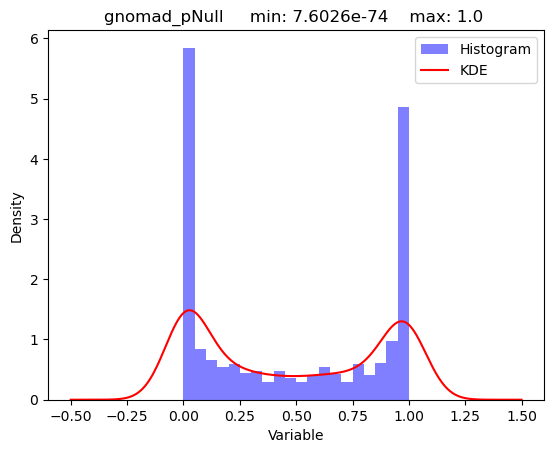

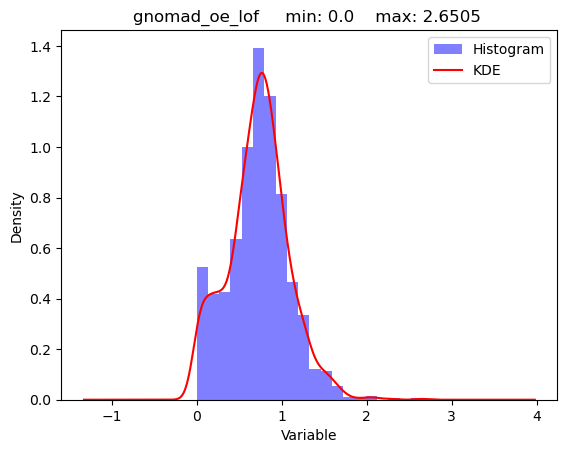

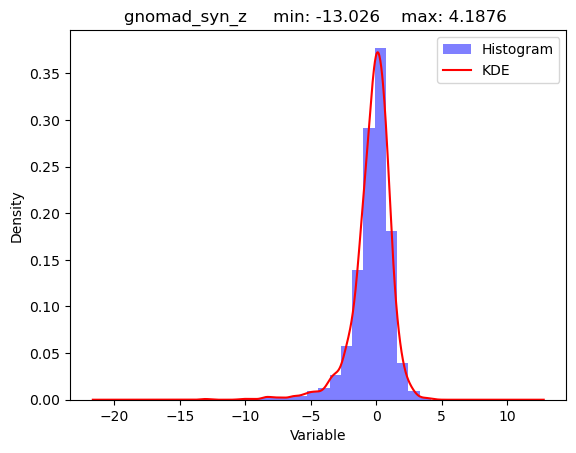

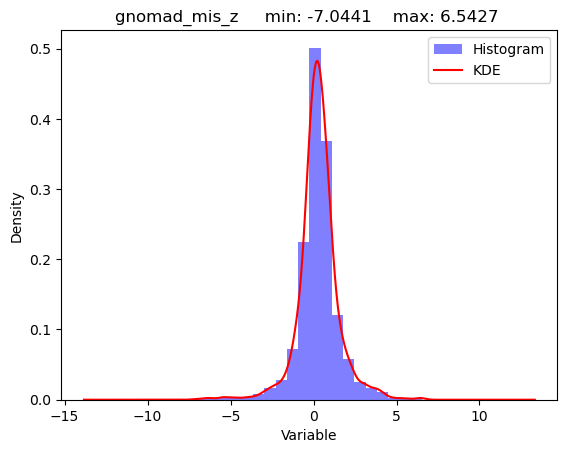

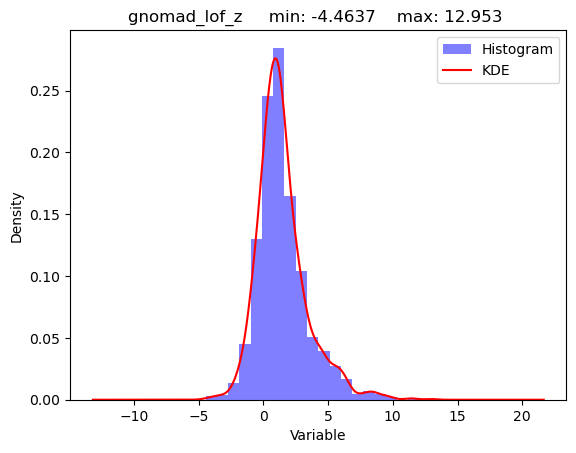

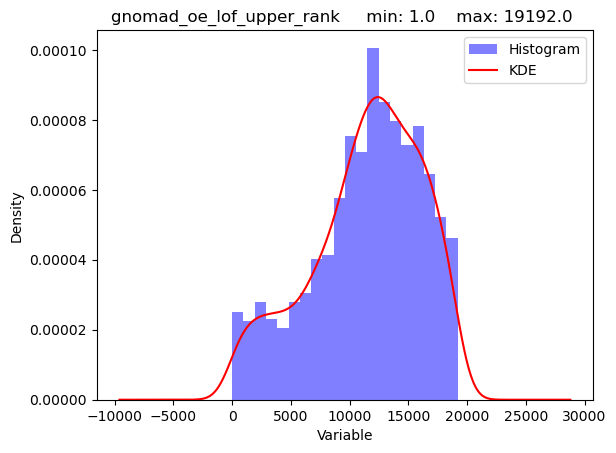

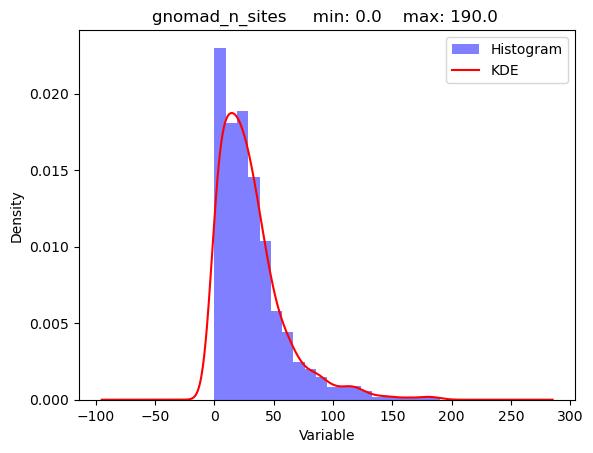

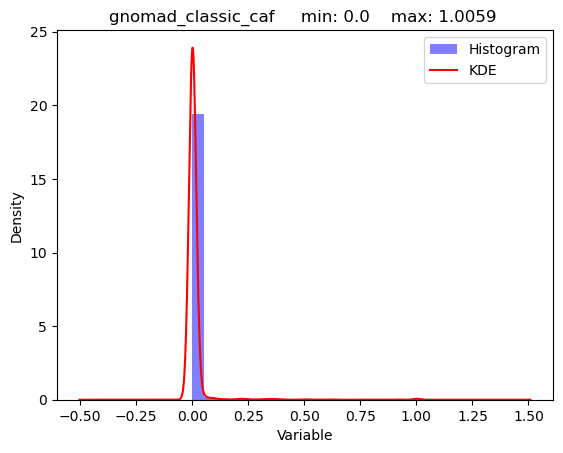

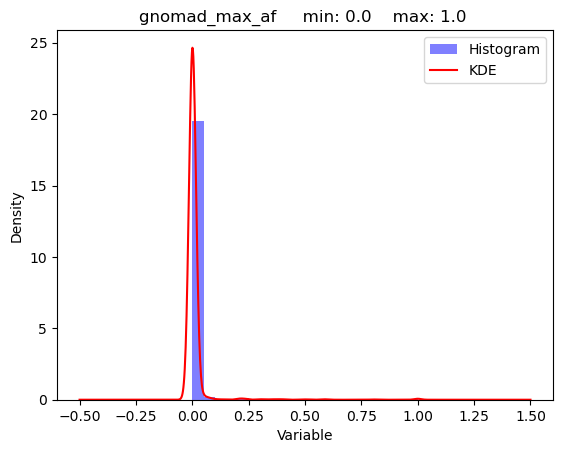

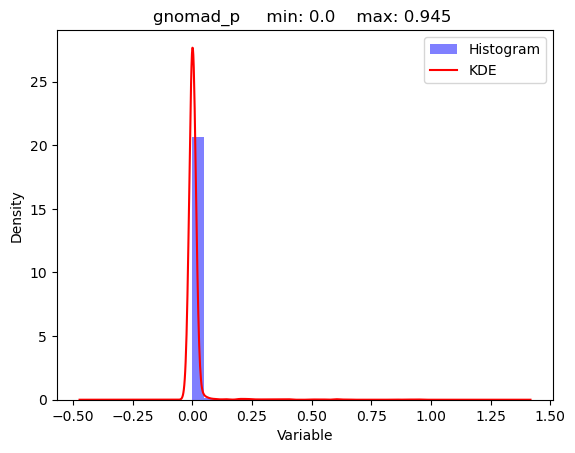

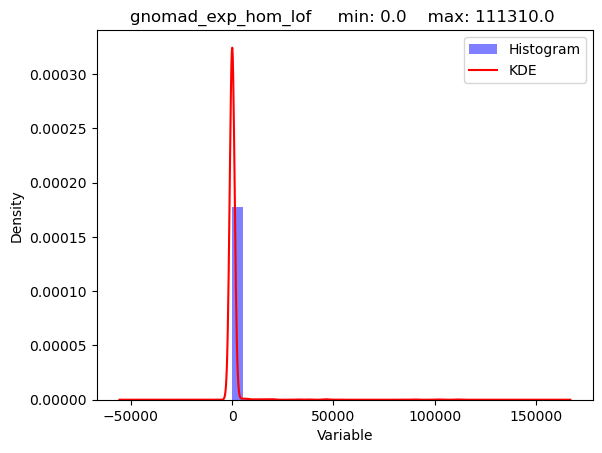

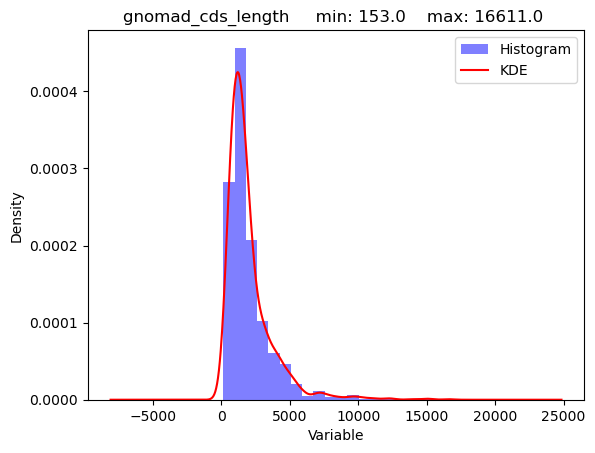

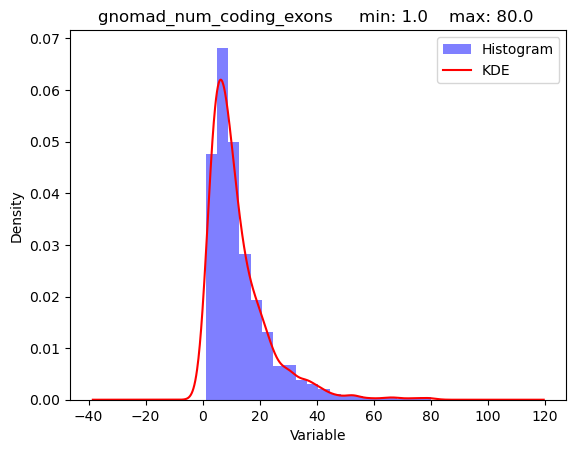

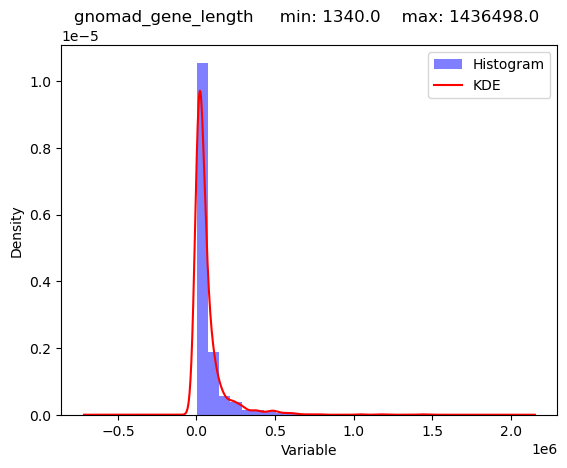

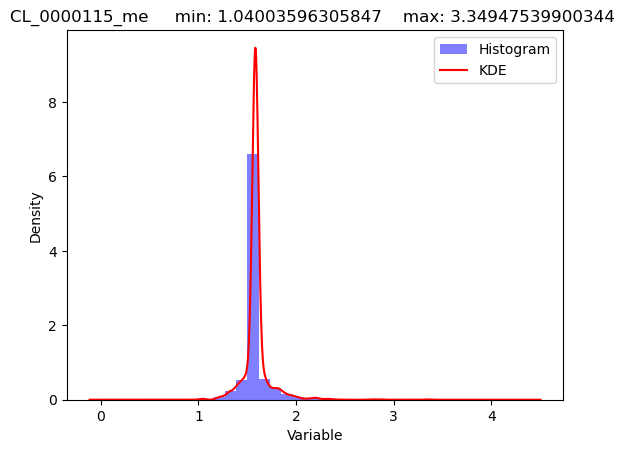

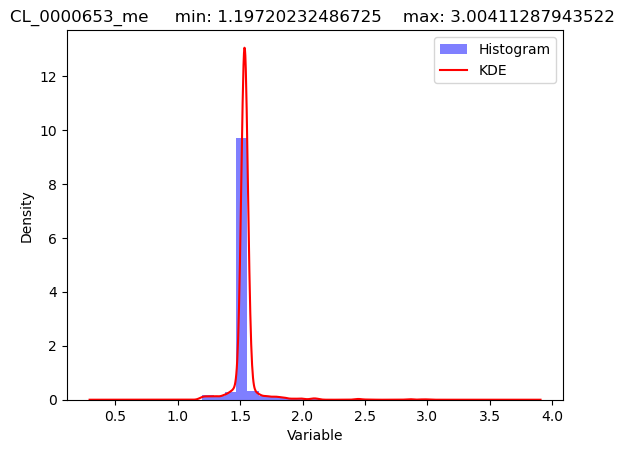

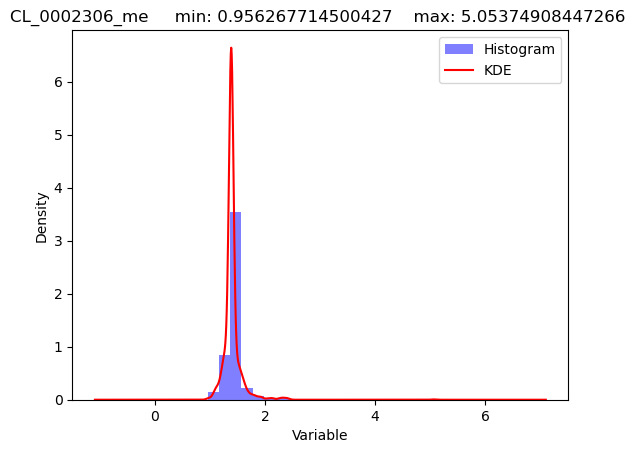

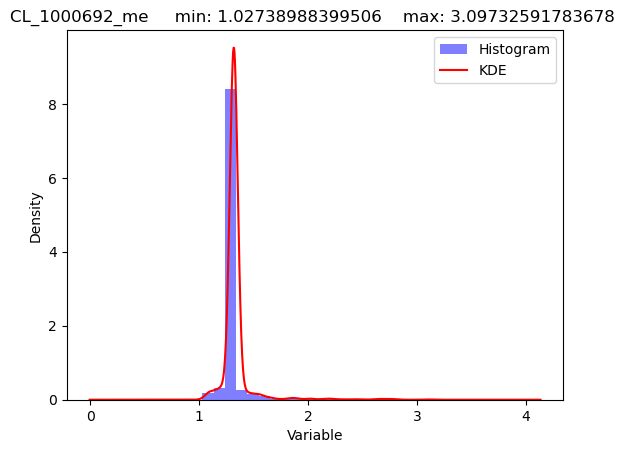

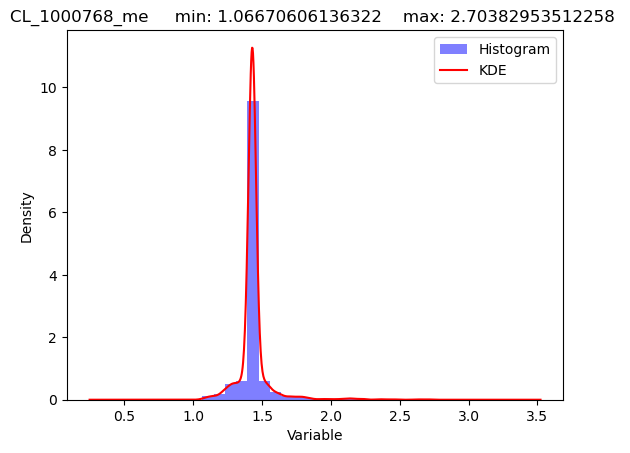

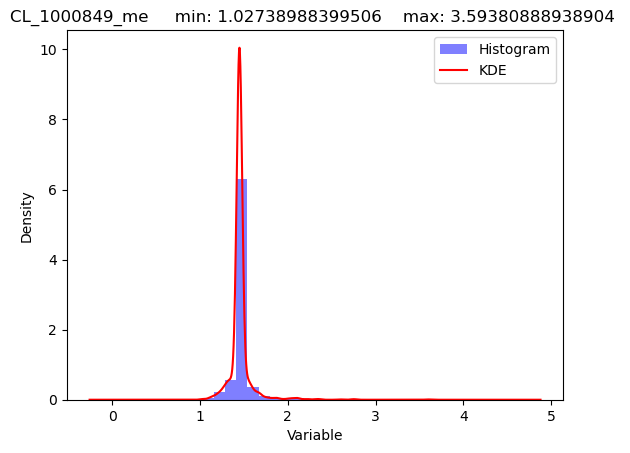

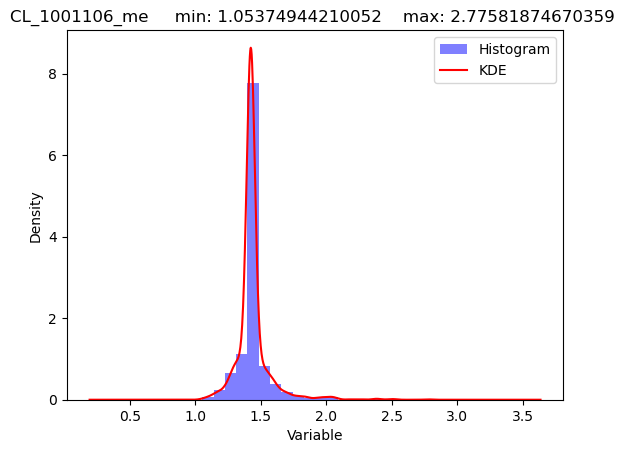

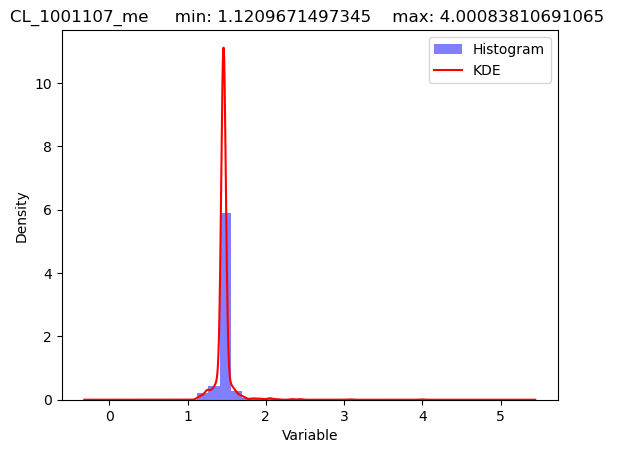

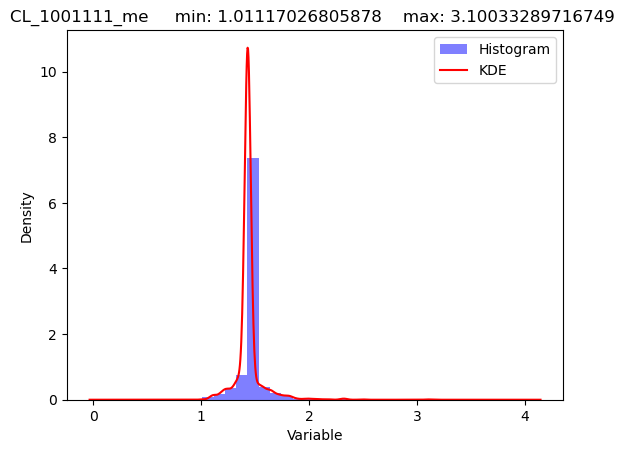

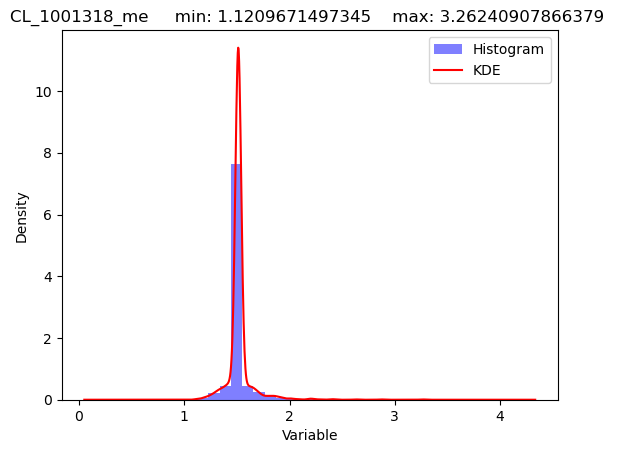

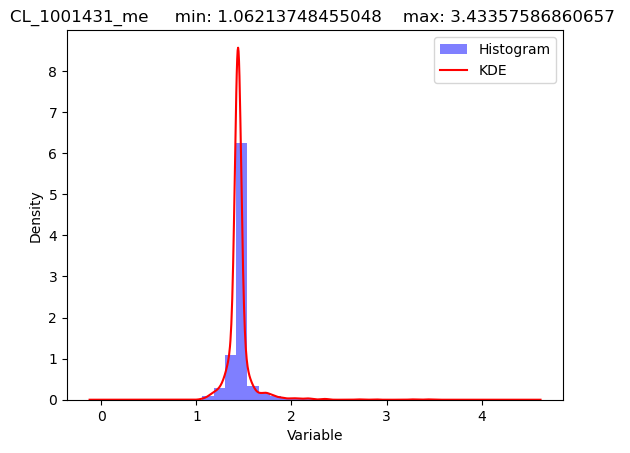

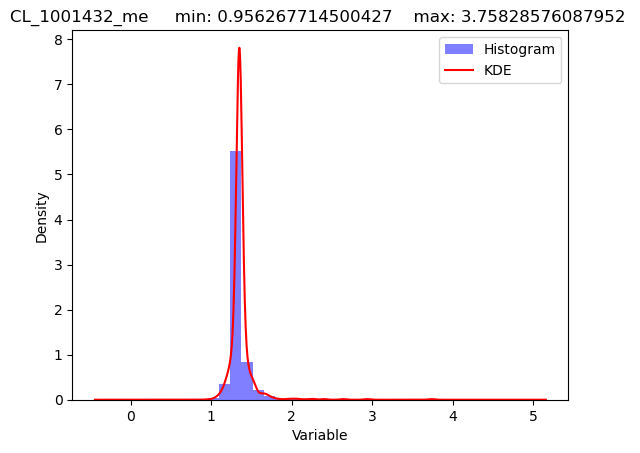

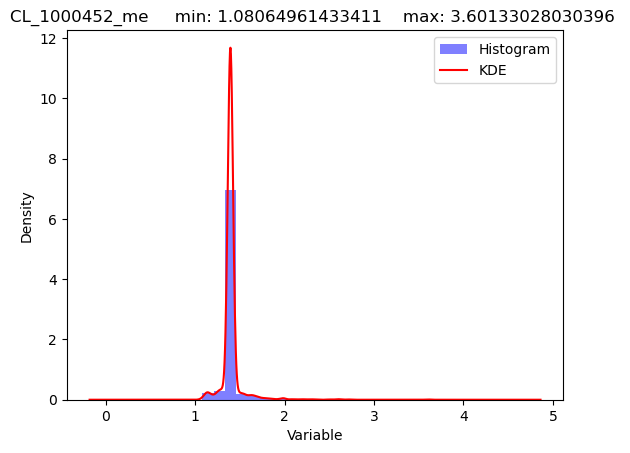

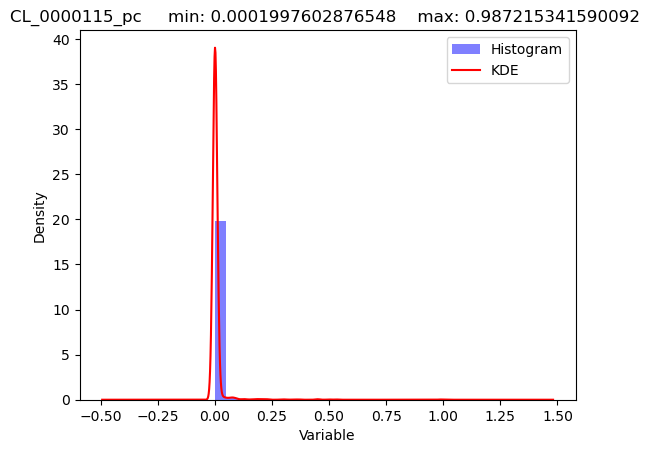

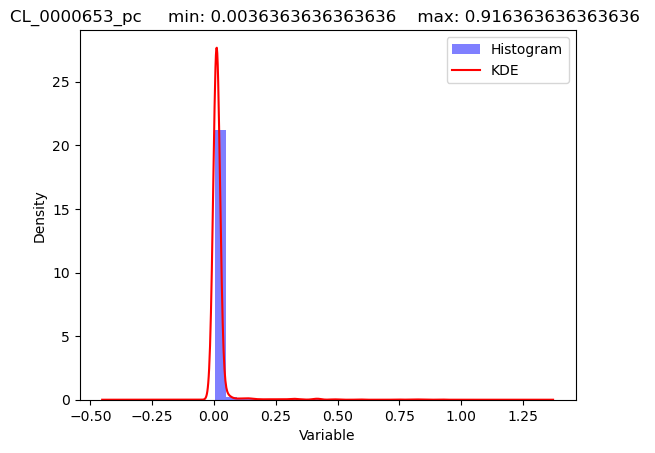

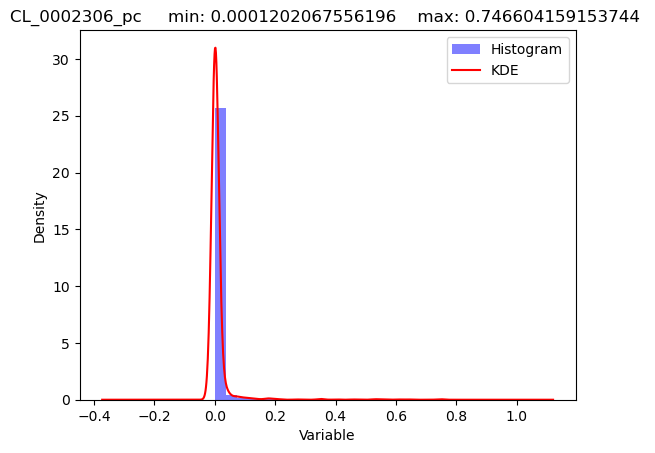

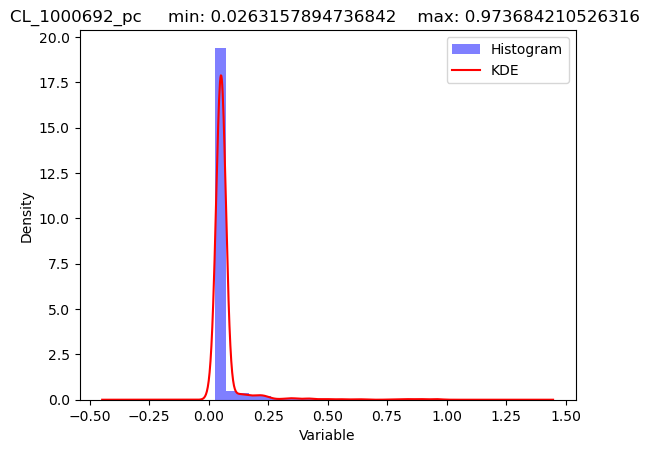

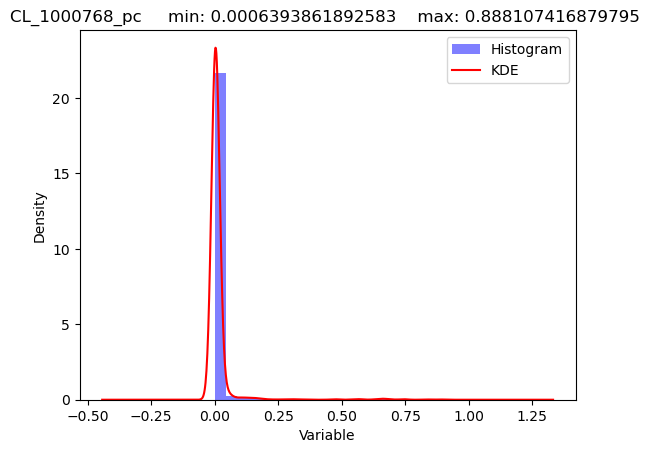

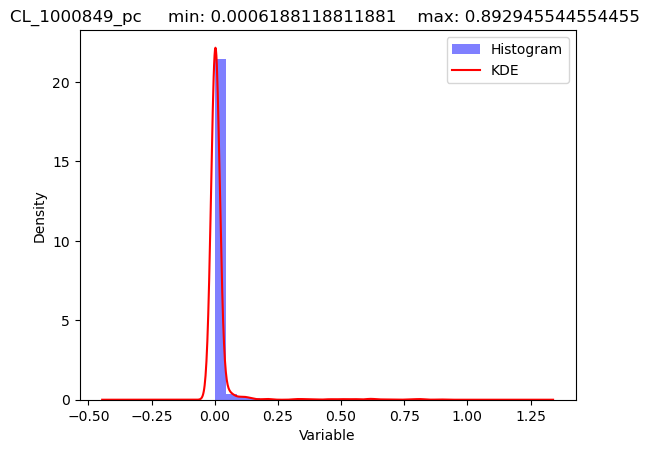

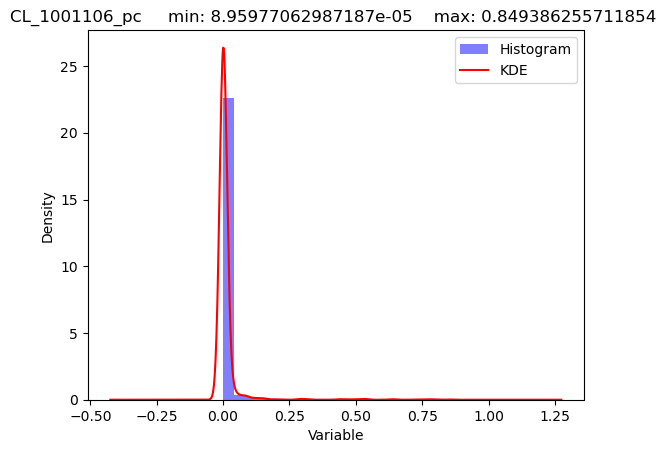

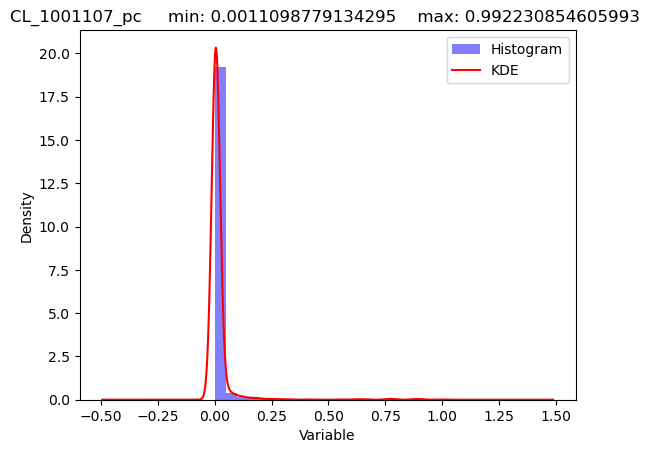

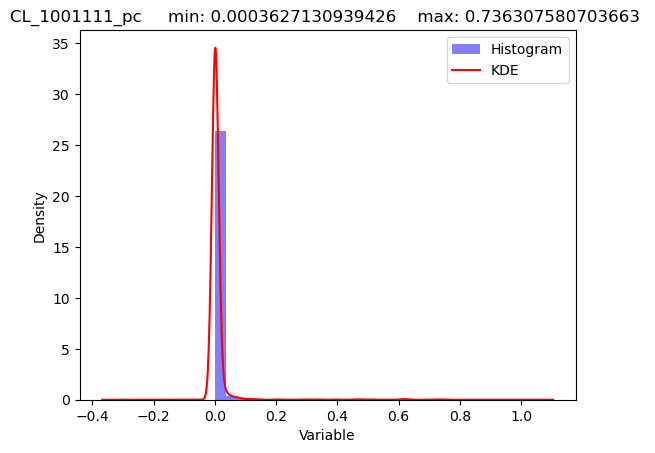

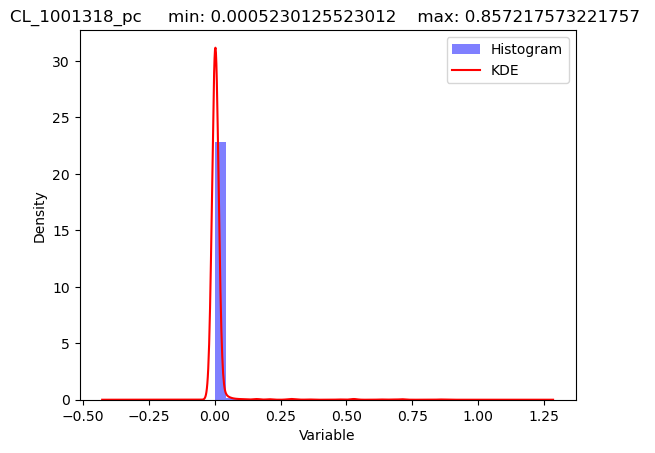

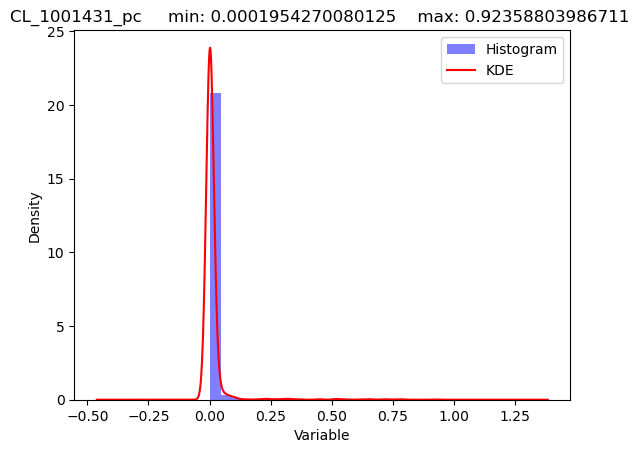

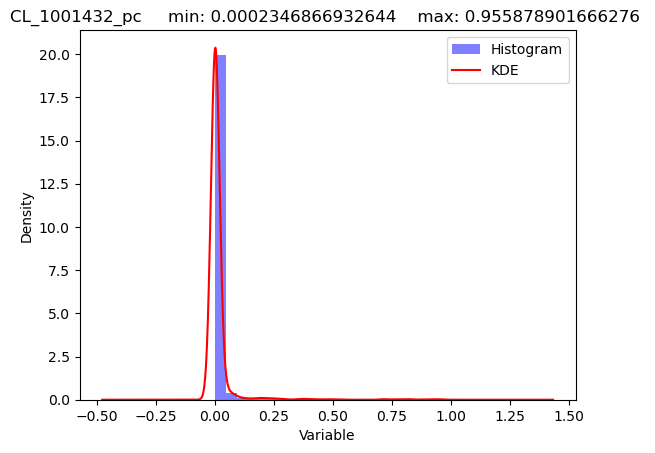

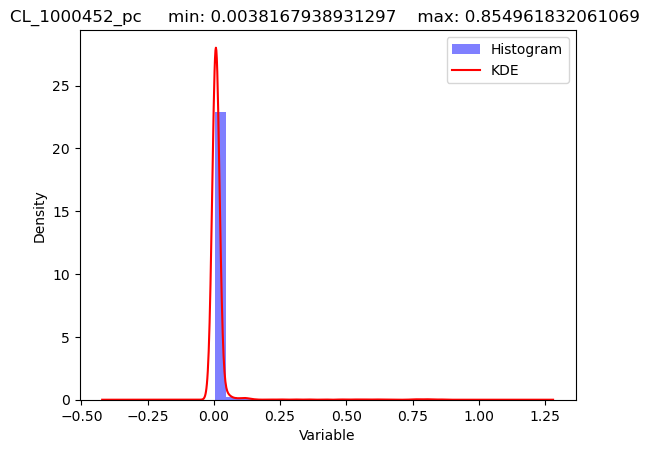

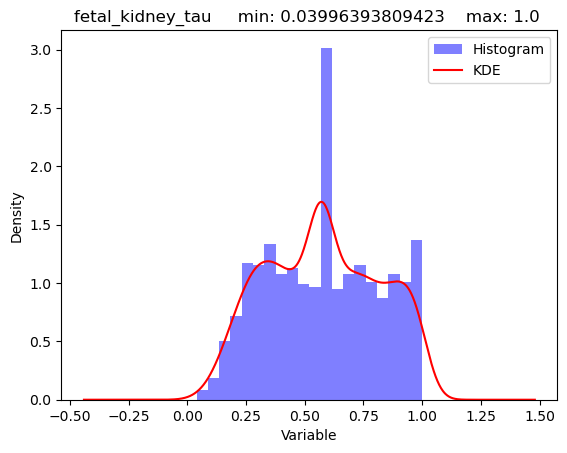

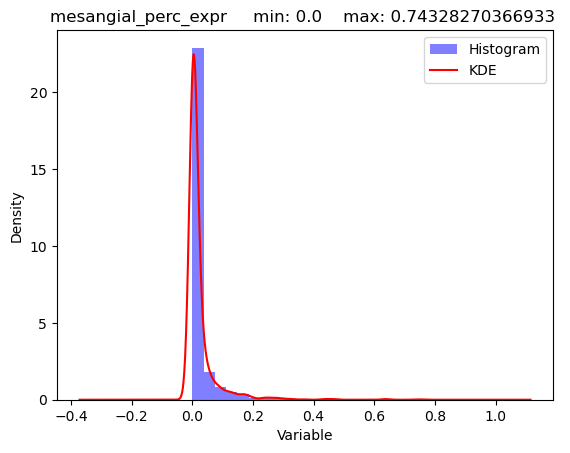

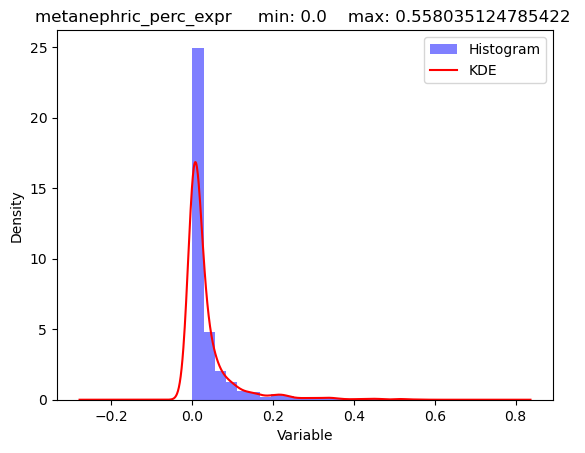

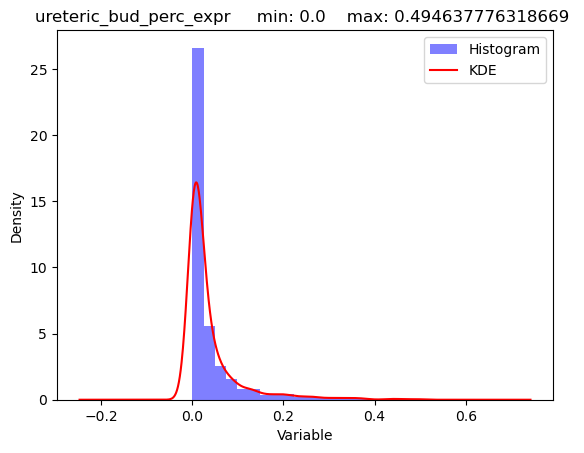

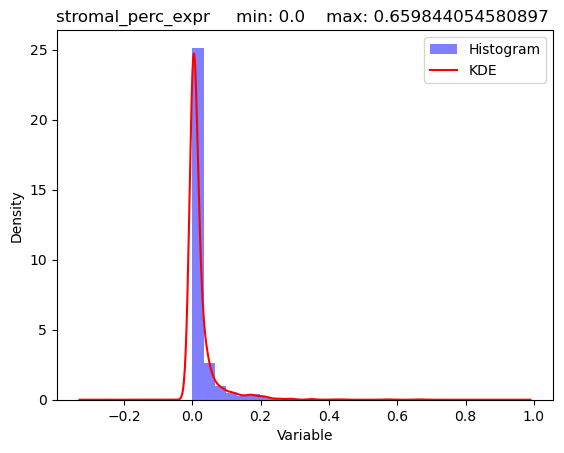

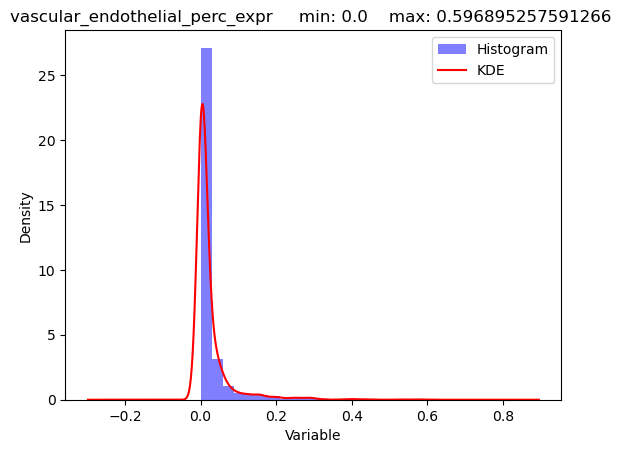

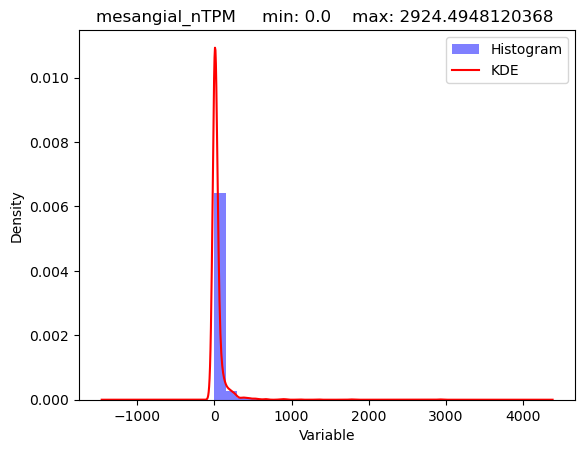

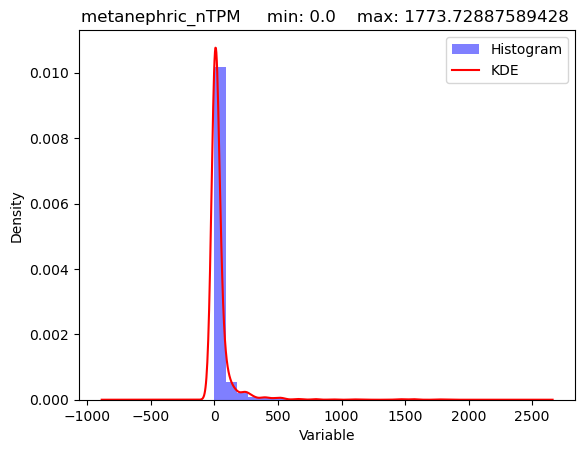

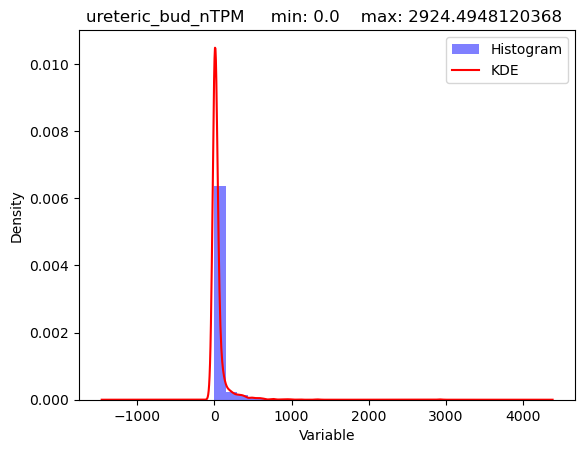

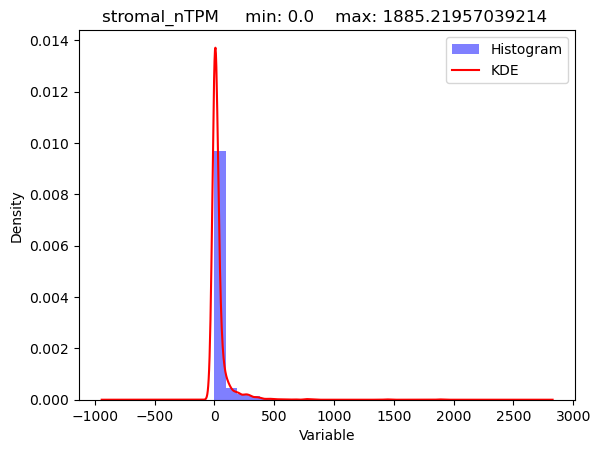

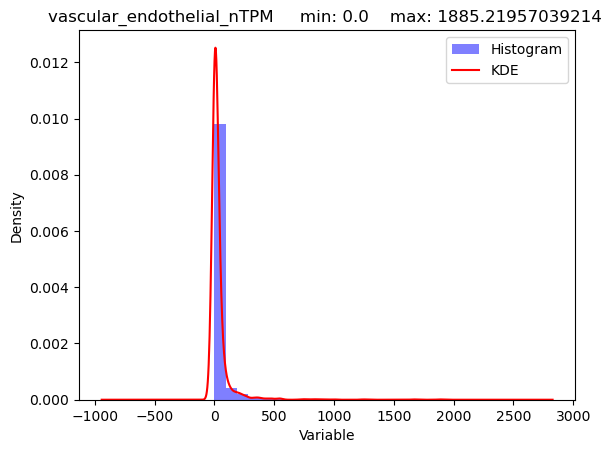

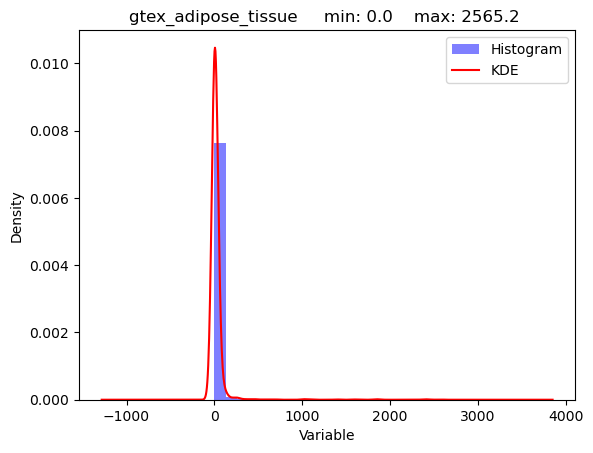

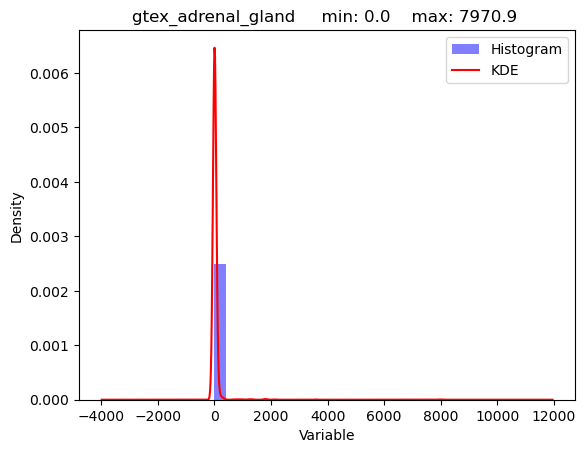

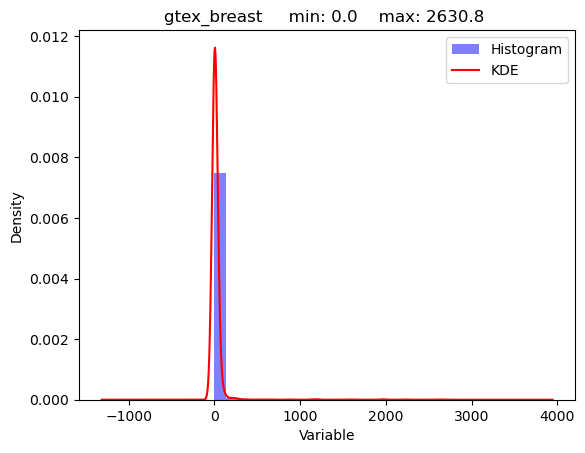

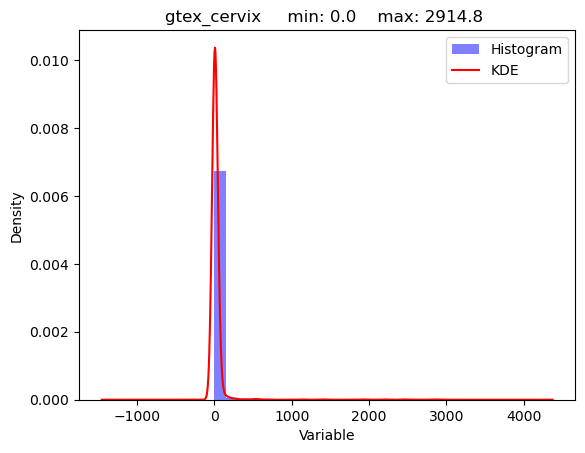

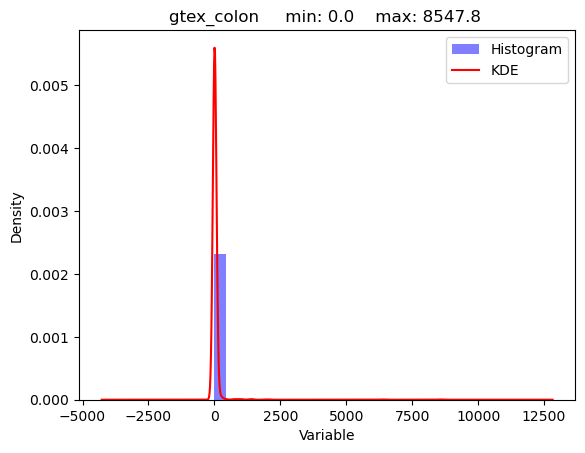

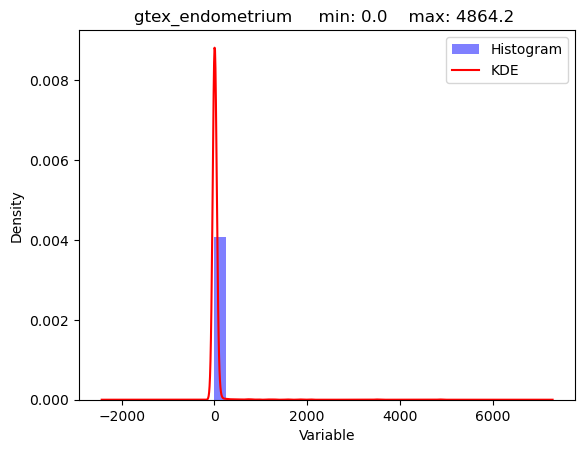

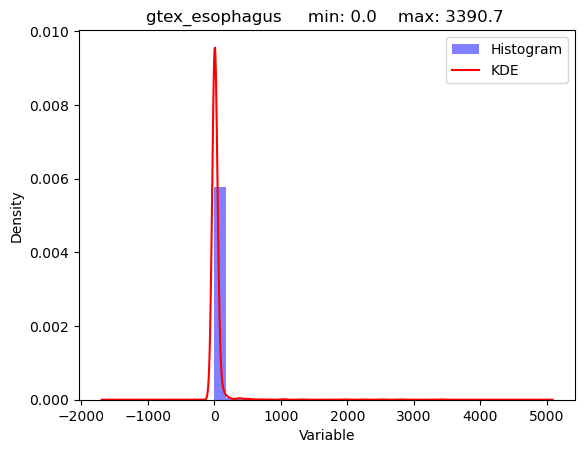

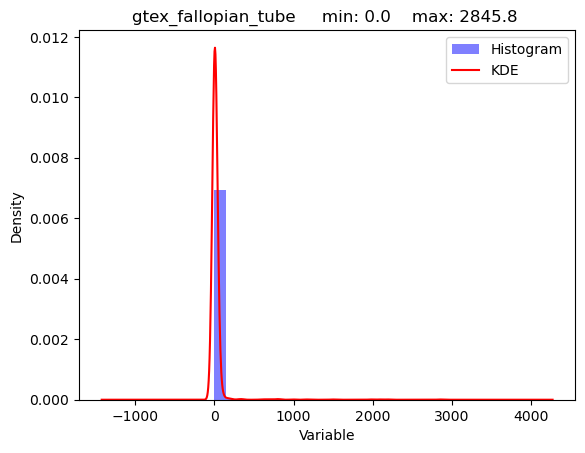

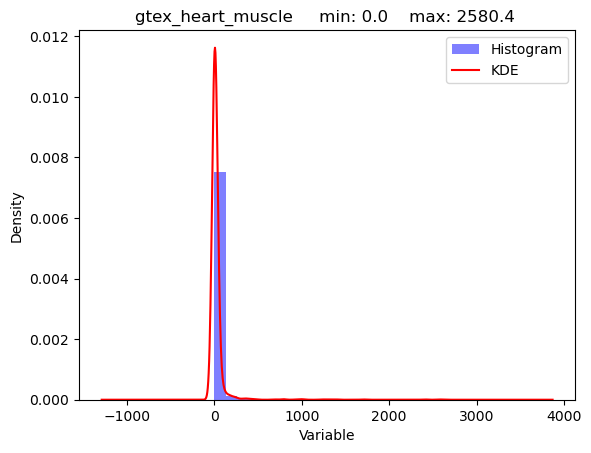

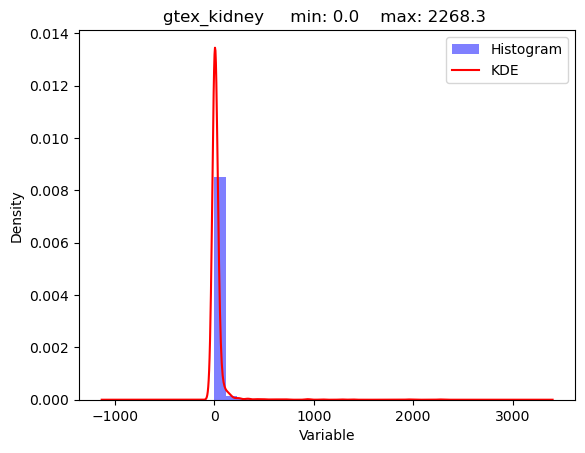

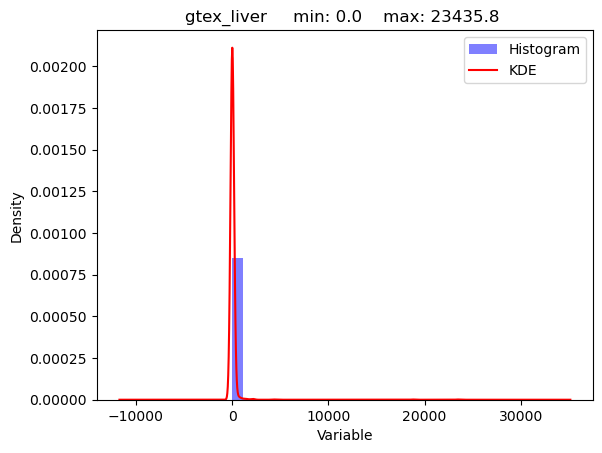

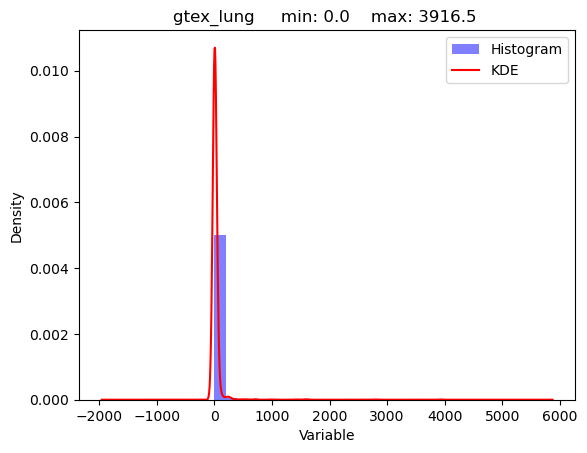

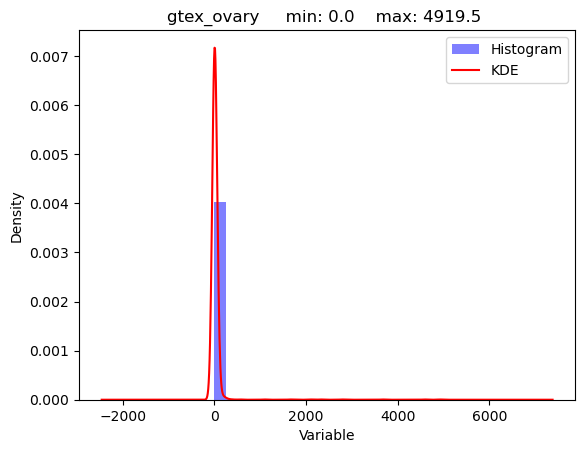

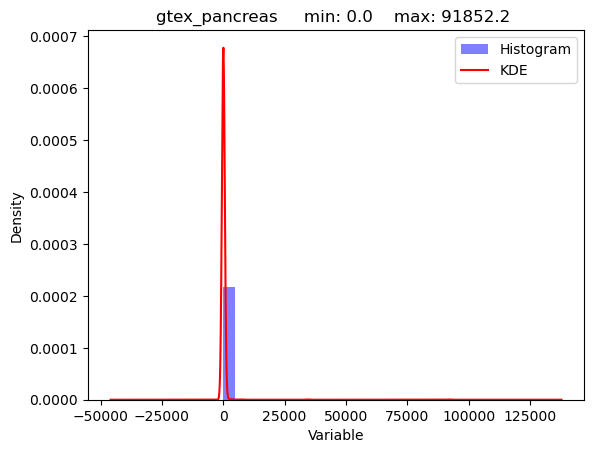

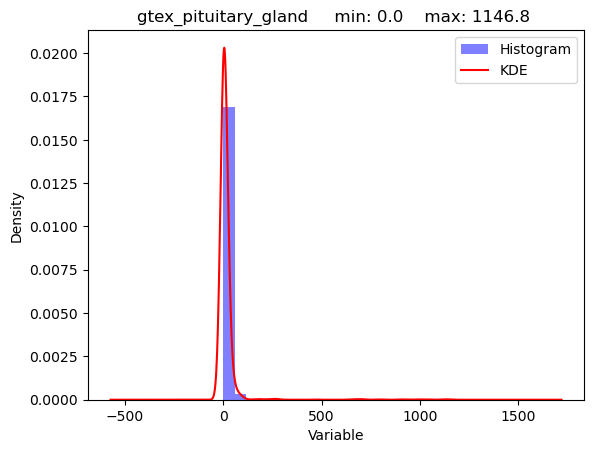

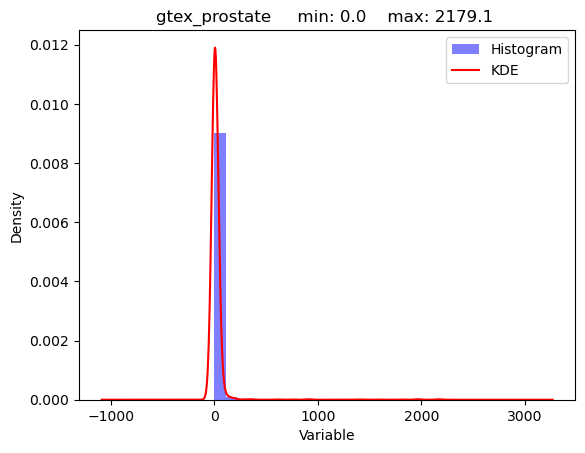

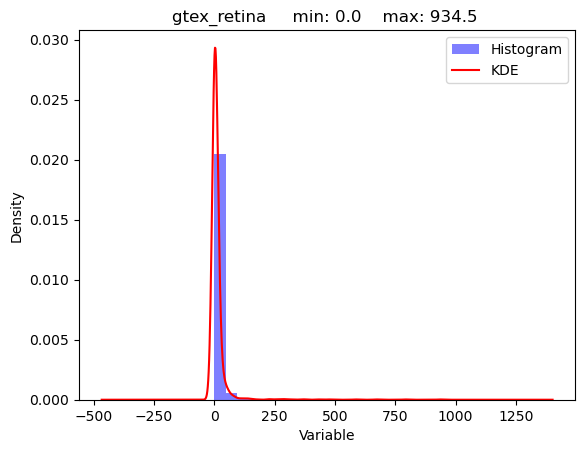

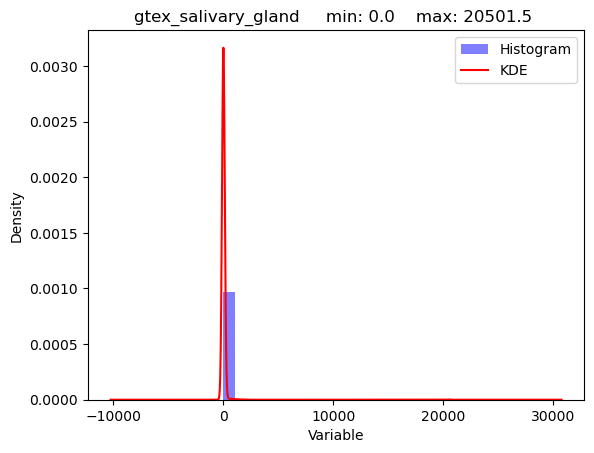

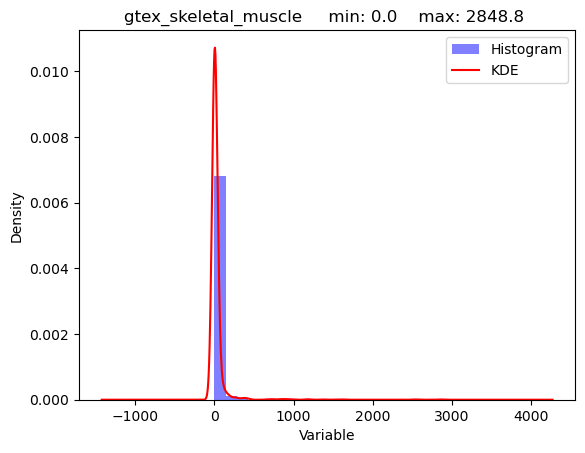

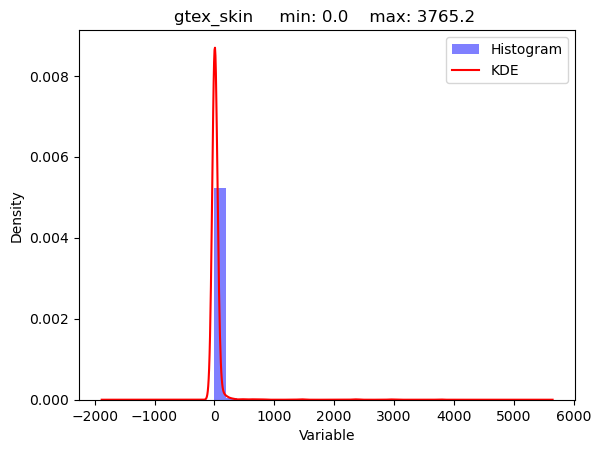

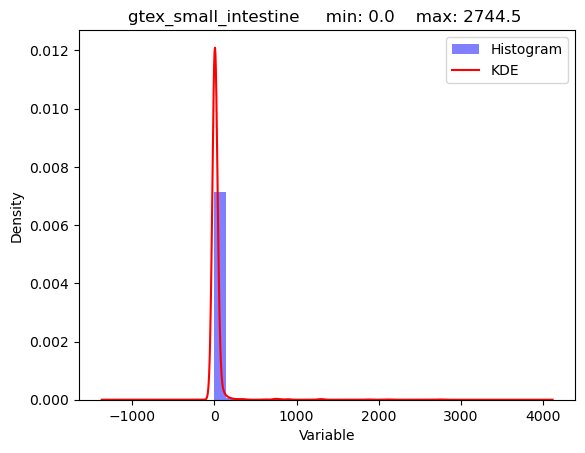

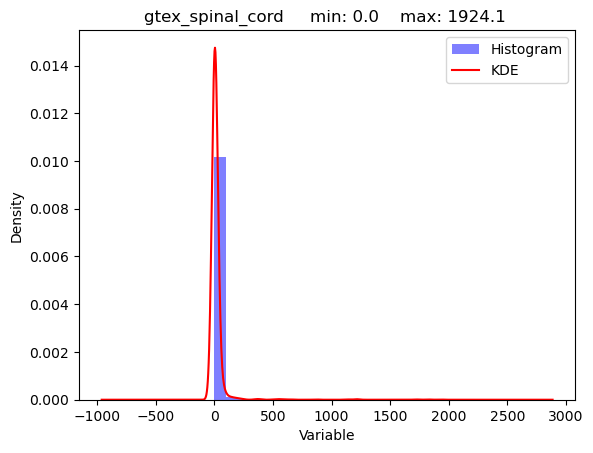

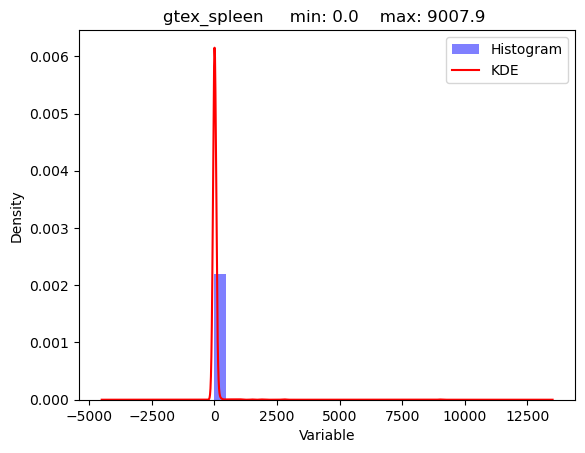

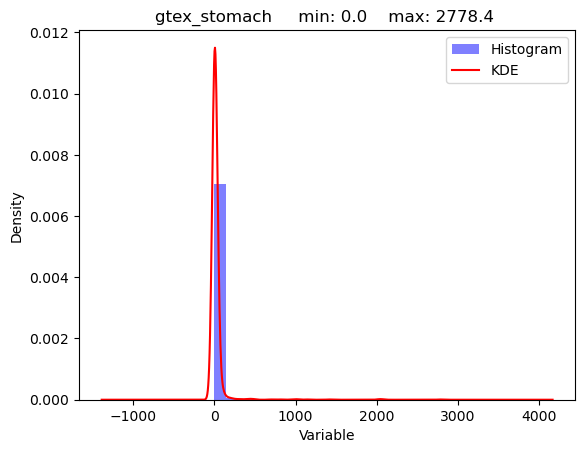

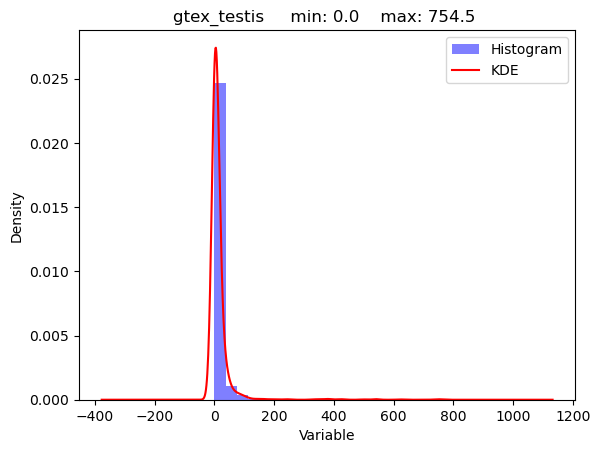

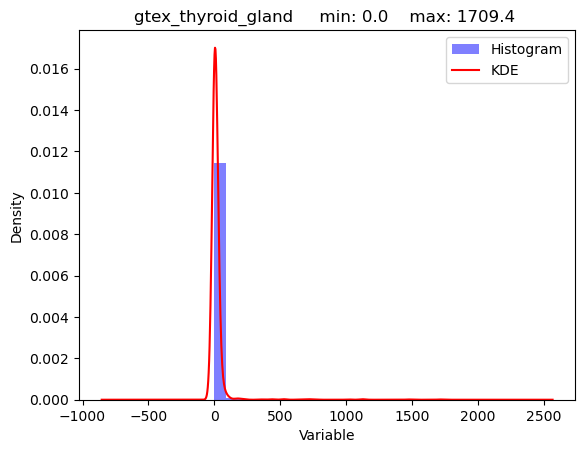

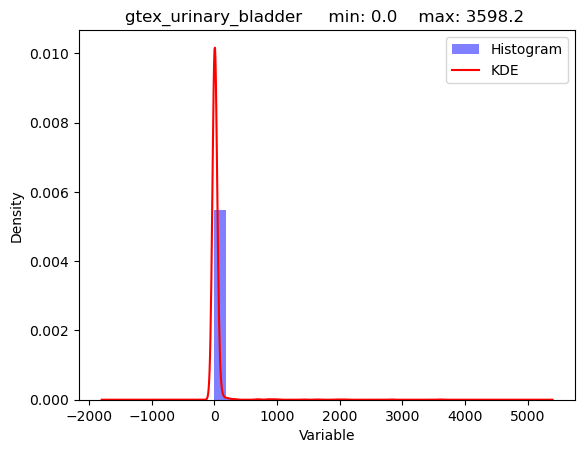

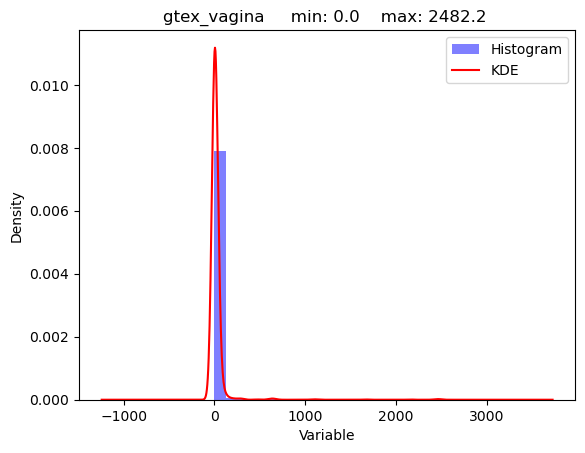

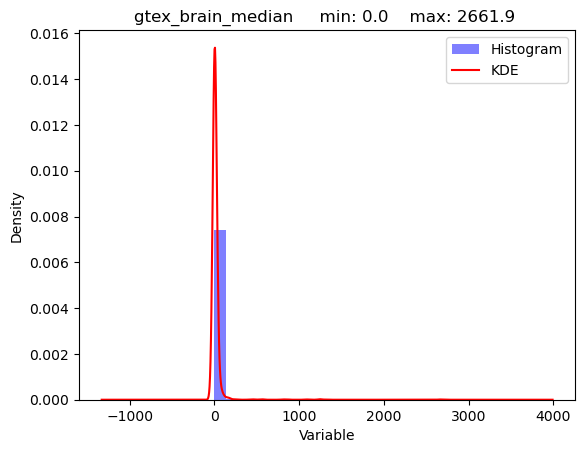

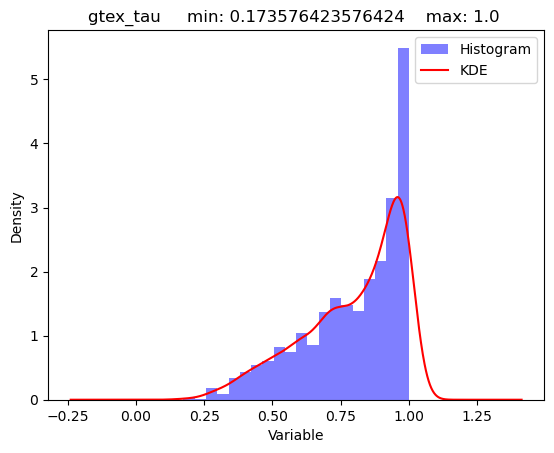

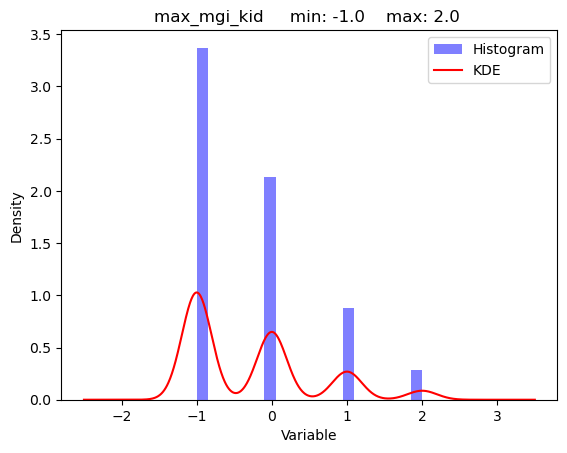

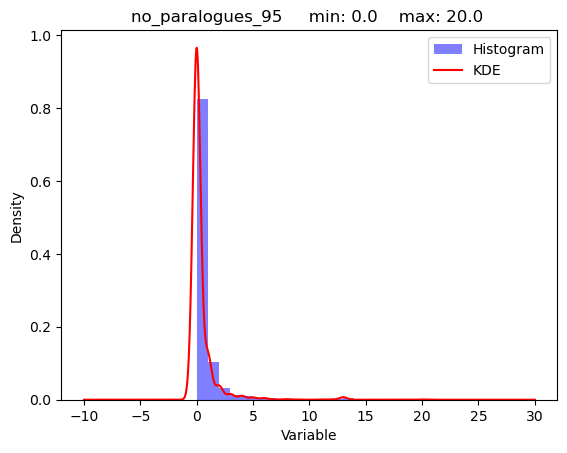

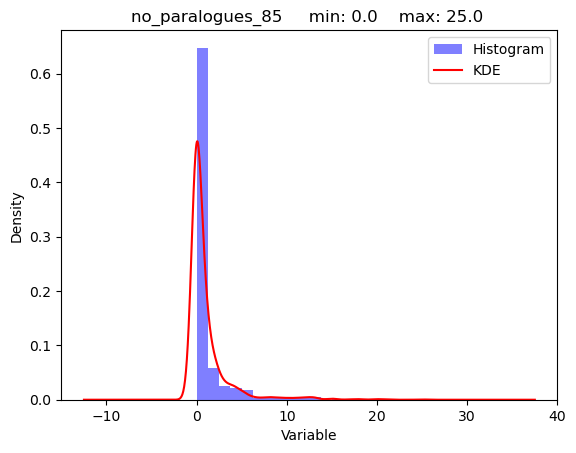

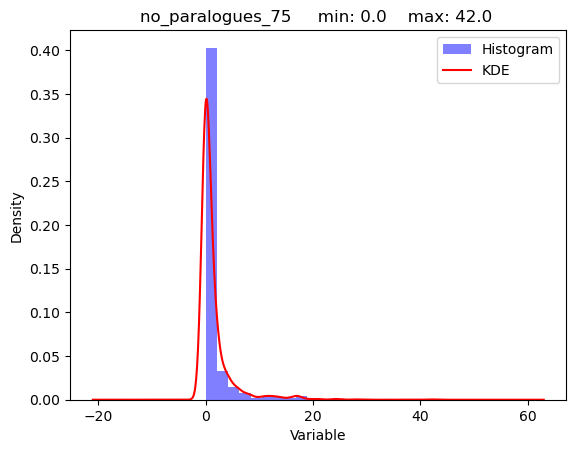

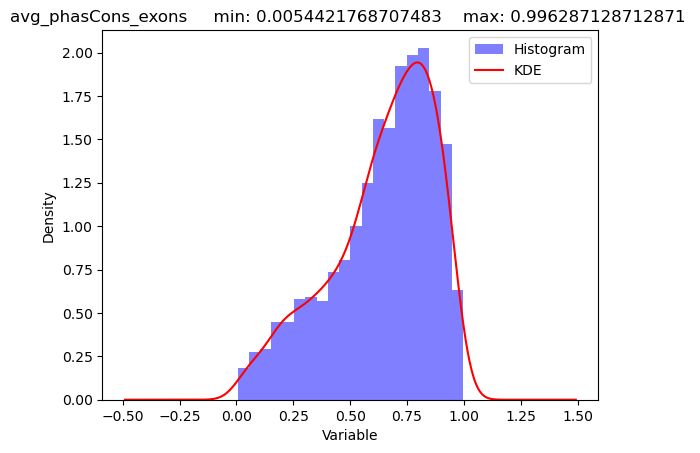

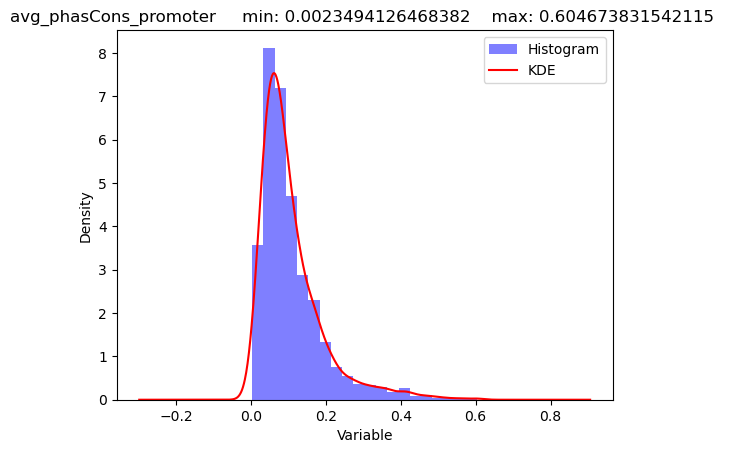

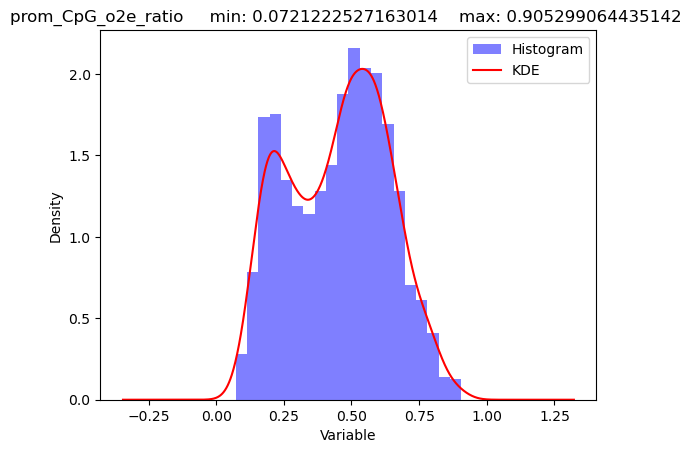

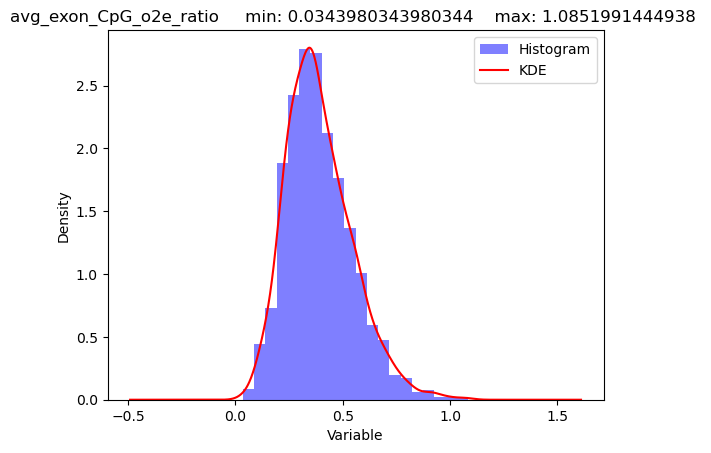

In [8]:
for var in feat_train.columns[1:111]:
    # Create a histogram with density=True to get normalized values
    plt.hist(feat_train[var], bins=20, density=True, alpha=0.5, color='b', label='Histogram')

    # Create a KDE plot
    feat_train[var].plot.kde(color='r', label='KDE')

    # Add labels and a legend
    plt.xlabel('Variable')
    plt.ylabel('Density')
    plt.legend()
    plt.title(f"{var}     min: {feat_train[var].min()}    max: {feat_train[var].max()} ")

    # Show the plot
    plt.show()




In [ ]:
## scale continues values using Standard Scaling
omit_scaling = get_features_from_groups(omit_scaling_features, feat_train) # features that should not be scaled
scaling_features = [i for i in features_selected if i not in omit_scaling] # features that should be scaled

# create StandardScaler
stand_scal = StandardScaler()

# scale features
feat_train_scaled = feat_train_filled.copy()
feat_train_scaled[scaling_features] = stand_scal.fit_transform(feat_train_scaled[scaling_features])
print('shape feat_train_scaled: ', feat_train_scaled.shape)

# join training labels with scaled training features 
labels_feat_train = pd.merge(labels_train, feat_train_scaled, on='hgnc_id_int', how='inner')
print('shape labels_feat_train: ', labels_feat_train.shape)


## scale continues values using Robust Scaling
omit_scaling = get_features_from_groups(omit_scaling_features, feat_train) # features that should not be scaled
scaling_features = [i for i in features_selected if i not in omit_scaling] # features that should be scaled

# create RobustScaler
stand_scal = RobustScaler()

# scale features
feat_train_scaled = feat_train_filled.copy()
feat_train_scaled[scaling_features] = stand_scal.fit_transform(feat_train_scaled[scaling_features])
print('shape feat_train_scaled: ', feat_train_scaled.shape)

# join training labels with scaled training features 
labels_feat_train = pd.merge(labels_train, feat_train_scaled, on='hgnc_id_int', how='inner')
print('shape labels_feat_train: ', labels_feat_train.shape)








In [ ]:
# get X_train and y_train as numpy arrays
X_train = labels_feat_train.drop(columns=['hgnc_id_int', 'ec2345']).values
y_train = labels_feat_train['ec2345'].values
print("shape X_train: ", X_train.shape)
print("shape y_train: ", y_train.shape)

In [91]:
# PCA of filled training data
from sklearn.decomposition import PCA


n_components = 2

X = feat_train_filled.drop(columns=['hgnc_id_int'])

pca = PCA(n_components=n_components)
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)

In [96]:
pca.fit_transform(X).shape




(1533, 2)

In [97]:
X.shape

(1533, 109)

In [48]:
pca.explained_variance_ratio_

array([0.99367389, 0.00236911])

In [49]:
loadings = pca.components_
loadings_df = pd.DataFrame(loadings, columns=X.columns, index=[f'PC{i+1}' for i in range(n_components)])


In [57]:
loadings_df

,gnomad_obs_mis,gnomad_exp_mis,gnomad_oe_mis,gnomad_mu_mis,gnomad_possible_mis,gnomad_obs_mis_pphen,gnomad_exp_mis_pphen,gnomad_oe_mis_pphen,gnomad_possible_mis_pphen,gnomad_obs_syn,...,gtex_brain_median,gtex_tau,max_mgi_kid,no_paralogues_95,no_paralogues_85,no_paralogues_75,avg_phasCons_exons,avg_phasCons_promoter,prom_CpG_o2e_ratio,avg_exon_CpG_o2e_ratio
PC1,0.000929,0.001017,-1.368397e-07,5.381394e-11,0.012984,0.000269,0.000363,-2.812957e-07,0.004600,0.000382,...,-0.000036,-1.079589e-07,2.941064e-07,-7.322843e-07,-0.000001,-0.000002,5.135632e-07,1.427124e-07,3.433302e-07,-1.613125e-07
PC2,0.000288,-0.000923,3.593059e-06,-5.075612e-11,-0.015900,0.000264,-0.000249,4.278485e-06,-0.004247,-0.000147,...,-0.000342,1.207870e-06,5.425970e-07,-1.552647e-06,0.000002,0.000002,-7.522208e-07,-6.893749e-07,-7.430911e-07,-6.166051e-07


In [55]:
# Sort the columns based on the loadings for PC1 in descending order
loadings_df_sorted = loadings_df.T.sort_values(by='PC1', ascending=False).T

# Print the sorted loadings_df
# print(loadings_df_sorted)
loadings_df_sorted

,gnomad_gene_length,gnomad_possible_mis,gnomad_cds_length,gnomad_possible_mis_pphen,gnomad_possible_syn,gnomad_possible_lof,gnomad_exp_mis,gnomad_obs_mis,metanephric_nTPM,ureteric_bud_nTPM,...,gtex_colon,gtex_ovary,gtex_skin,gtex_spleen,gtex_adrenal_gland,gtex_salivary_gland,gtex_liver,gtex_pancreas,gnomad_exp_hom_lof,gnomad_oe_lof_upper_rank
PC1,0.999776,0.012984,0.005904,0.004600,0.003664,0.001326,0.001017,0.000929,0.000574,0.000510,...,-0.000081,-0.000082,-0.000085,-0.000097,-0.000103,-0.000119,-0.000266,-0.000543,-0.000863,-0.014255
PC2,0.002271,-0.015900,-0.007180,-0.004247,-0.004602,-0.001449,-0.000923,0.000288,-0.000637,-0.000726,...,-0.000922,-0.000816,-0.000681,-0.000525,-0.000671,-0.000449,-0.000564,-0.001905,0.996709,0.078775


1436498.0

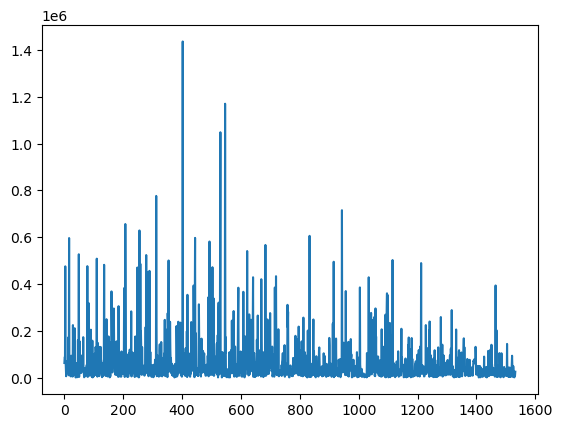

In [63]:
plt.plot(X['gnomad_gene_length'])
X['gnomad_gene_length'].max()
# X['gnomad_gene_length'].min()

In [53]:
loadings_pc1_abs

gnomad_obs_mis                    9.293568e-04
gnomad_exp_mis                    1.017028e-03
gnomad_oe_mis                     1.368397e-07
gnomad_mu_mis                     5.381394e-11
gnomad_possible_mis               1.298447e-02
gnomad_obs_mis_pphen              2.689653e-04
gnomad_exp_mis_pphen              3.628068e-04
gnomad_oe_mis_pphen               2.812957e-07
gnomad_possible_mis_pphen         4.600264e-03
gnomad_obs_syn                    3.819368e-04
gnomad_exp_syn                    3.672331e-04
gnomad_oe_syn                     4.053036e-09
gnomad_mu_syn                     2.079445e-11
gnomad_possible_syn               3.663834e-03
gnomad_obs_lof                    4.186472e-05
gnomad_mu_lof                     5.793099e-12
gnomad_possible_lof               1.326063e-03
gnomad_exp_lof                    1.062135e-04
gnomad_pLI                        4.567153e-07
gnomad_pRec                       1.175216e-07
gnomad_pNull                      5.737979e-07
gnomad_oe_lof

<Figure size 1000x600 with 0 Axes>

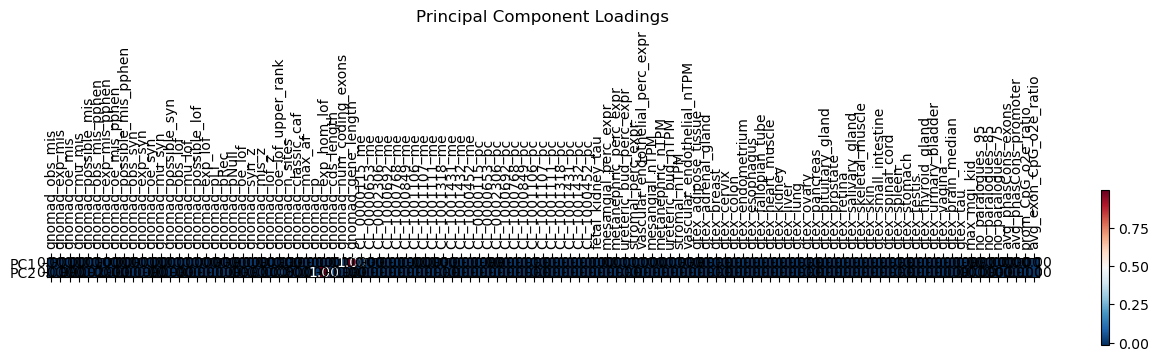

In [51]:
import matplotlib.pyplot as plt

# Customize the size of the heatmap
plt.figure(figsize=(10, 6))

# Create the heatmap using Matplotlib
cax = plt.matshow(loadings, cmap='RdBu_r')
plt.colorbar(cax)

# Set the x and y-axis labels
plt.xticks(range(len(X.columns)), X.columns, rotation='vertical')
plt.yticks(range(n_components), [f'PC{i+1}' for i in range(n_components)])

# Add annotations for loadings
for i in range(n_components):
    for j in range(len(X.columns)):
        plt.text(j, i, f'{loadings[i, j]:.2f}', ha='center', va='center', color='w' if abs(loadings[i, j]) > 0.5 else 'k')

# Add a title
plt.title('Principal Component Loadings')

# Show the heatmap
plt.show()


In [35]:
# from sklearn.preprocessing import StandardScaler

# robust_scaler = RobustScaler()
# scaled_data1 = robust_scaler.fit_transform(feat_train_filled.drop(columns=['hgnc_id_int']))



# standard_scaler = StandardScaler()
# scaled_data = standard_scaler.fit_transform(scaled_data1)



In [86]:
# PCA using standard scaling
from sklearn.preprocessing import StandardScaler

standard_scaler = StandardScaler()
scaled_data = standard_scaler.fit_transform(feat_train_filled.drop(columns=['hgnc_id_int']))

n_components=100

pca = PCA(n_components=n_components)
pca.fit(scaled_data)
cumsum = np.cumsum(pca.explained_variance_ratio_)

# n_components = 2  # Number of components to retain
# pca = PCA(n_components=n_components)
# principal_components = pca.fit_transform(scaled_data)

loadings = pca.components_
loadings_df = pd.DataFrame(loadings, columns=X.columns, index=[f'PC{i+1}' for i in range(n_components)])
loadings_df.head(3)

,gnomad_obs_mis,gnomad_exp_mis,gnomad_oe_mis,gnomad_mu_mis,gnomad_possible_mis,gnomad_obs_mis_pphen,gnomad_exp_mis_pphen,gnomad_oe_mis_pphen,gnomad_possible_mis_pphen,gnomad_obs_syn,...,gtex_brain_median,gtex_tau,max_mgi_kid,no_paralogues_95,no_paralogues_85,no_paralogues_75,avg_phasCons_exons,avg_phasCons_promoter,prom_CpG_o2e_ratio,avg_exon_CpG_o2e_ratio
PC1,-0.014395,-0.007266,-0.044364,-0.005574,-0.008472,-0.016254,-0.005425,-0.050273,-0.006698,-0.005635,...,0.138938,-0.021352,0.003705,0.008487,0.008791,0.006040,0.028627,0.016070,0.023777,0.029011
PC2,0.216693,0.229584,-0.027859,0.225090,0.226370,0.198992,0.218760,-0.039053,0.216096,0.218966,...,-0.016220,-0.033500,0.022917,-0.024562,-0.025464,-0.026804,0.051501,0.059402,0.057469,-0.015107
PC3,-0.131731,-0.076589,-0.218243,-0.075990,-0.076969,-0.131088,-0.050544,-0.220444,-0.057542,-0.101714,...,-0.032758,-0.126478,0.040699,-0.048138,-0.046423,-0.045586,0.145759,0.148194,0.149575,0.033549


In [87]:
# dimensions
dim = np.argmax(cumsum>= 0.95) +1
dim

43

In [88]:
# Sort the columns based on the loadings for PC1 in descending order
loadings_df_sorted = loadings_df.T.sort_values(by='PC1', ascending=False).T

# Print the sorted loadings_df
# print(loadings_df_sorted)
loadings_df_sorted

,gtex_breast,gtex_fallopian_tube,gtex_cervix,gtex_vagina,CL_1001111_pc,gtex_adipose_tissue,gtex_thyroid_gland,gtex_spinal_cord,CL_1000452_pc,gtex_pituitary_gland,...,fetal_kidney_tau,gnomad_obs_mis_pphen,gtex_tau,gnomad_n_sites,gnomad_obs_lof,gnomad_pNull,gnomad_oe_lof_upper_rank,gnomad_oe_lof,gnomad_oe_mis,gnomad_oe_mis_pphen
PC1,0.163305,0.163199,0.162396,0.162313,0.162103,0.159879,0.159116,0.157929,0.157326,0.156186,...,-0.015930,-0.016254,-0.021352,-0.022492,-0.024711,-0.032229,-0.039713,-0.040556,-0.044364,-0.050273
PC2,-0.013812,-0.010780,-0.011824,-0.013378,-0.007266,-0.013465,-0.012840,-0.013473,-0.008633,-0.010561,...,-0.020874,0.198992,-0.033500,0.137262,0.141923,-0.053862,-0.139404,-0.084866,-0.027859,-0.039053
PC3,-0.035259,-0.037816,-0.034689,-0.038747,-0.015915,-0.040285,-0.036812,-0.033946,-0.017376,-0.017499,...,-0.085990,-0.131088,-0.126478,-0.179849,-0.201810,-0.213984,-0.190052,-0.224561,-0.218243,-0.220444
PC4,-0.120068,-0.144700,-0.130886,-0.135483,0.065590,-0.118886,-0.109052,-0.117102,0.037023,-0.091945,...,0.115369,-0.010515,0.110119,-0.017214,-0.010824,0.002533,0.004118,-0.008500,0.000524,-0.005529
PC5,-0.012600,-0.018121,-0.011176,-0.014945,0.007242,-0.015051,-0.016448,-0.011813,0.001212,0.010385,...,-0.039142,0.003704,-0.043306,0.057324,0.069115,0.201263,0.161590,0.201751,0.237670,0.204784
PC6,-0.006074,-0.009677,-0.004174,-0.005665,0.013714,-0.011413,-0.010065,-0.010486,0.013022,-0.007539,...,-0.016674,-0.009274,0.006888,-0.006856,-0.030437,-0.060171,-0.056093,-0.072406,-0.071691,-0.064377
PC7,-0.029161,0.021998,-0.032277,-0.016504,-0.094973,0.025155,0.024029,0.026576,-0.096433,-0.019672,...,0.140054,-0.010893,0.108703,-0.149293,-0.144480,-0.125212,-0.095107,-0.085692,0.003198,-0.056000
PC8,0.005825,-0.018428,-0.024500,-0.021043,-0.107940,0.082576,0.112535,0.094962,-0.093333,0.092019,...,-0.039304,-0.019831,-0.008245,0.044243,0.035197,0.047602,0.032489,0.088379,-0.028127,-0.036175
PC9,-0.008444,0.035929,0.006628,0.014412,-0.021954,0.003609,-0.026292,-0.008834,-0.032668,-0.046111,...,0.103230,-0.041839,0.177717,0.107439,0.141662,0.186110,0.129456,0.133667,-0.210954,-0.102243
PC10,-0.014459,0.070118,-0.002122,0.010406,-0.044814,0.011997,-0.053801,-0.030503,-0.036758,-0.112976,...,0.223459,0.023657,0.116127,-0.041814,-0.050235,-0.018858,-0.029538,-0.034727,0.026702,0.028394


In [89]:
cumsum

array([0.29305834, 0.45161974, 0.52413734, 0.56718299, 0.60572604,
       0.64076779, 0.66721634, 0.69102141, 0.71077662, 0.72756821,
       0.74253899, 0.75588809, 0.76872093, 0.77947477, 0.78946255,
       0.79911855, 0.80840938, 0.81750788, 0.82653043, 0.83512103,
       0.84296591, 0.8505551 , 0.85793082, 0.86488025, 0.87136137,
       0.87752174, 0.88337849, 0.88879473, 0.89413104, 0.89929596,
       0.90431579, 0.90914872, 0.9137649 , 0.91818611, 0.92239983,
       0.92658344, 0.93073037, 0.93474222, 0.9386788 , 0.94215539,
       0.94535805, 0.94852056, 0.9516119 , 0.9544629 , 0.95718048,
       0.95974924, 0.9622091 , 0.96456711, 0.96677592, 0.96879792,
       0.97075943, 0.97265471, 0.97448155, 0.9761663 , 0.97771275,
       0.97920121, 0.98056468, 0.98185742, 0.98307648, 0.98422308,
       0.98525394, 0.98624767, 0.98723451, 0.98818673, 0.98911331,
       0.98997184, 0.99078131, 0.99152651, 0.99224476, 0.99290446,
       0.99352057, 0.9940778 , 0.99461893, 0.99511775, 0.99559

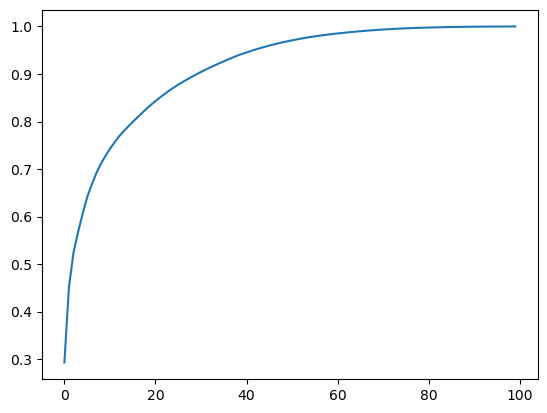

In [90]:
plt.plot(cumsum)

In [79]:
pca.explained_variance_ratio_

array([0.29305834, 0.1585614 , 0.07251761, 0.04304564, 0.03854305,
       0.03504175, 0.02644855, 0.02380507, 0.01975521, 0.01679159,
       0.01497078, 0.0133491 , 0.01283284, 0.01075384, 0.00998778,
       0.00965599, 0.00929083, 0.00909849, 0.00902255, 0.00859059,
       0.00784488, 0.00758918, 0.00737572, 0.00694941, 0.0064811 ,
       0.00616034, 0.00585673, 0.00541562, 0.0053362 , 0.00516489,
       0.00501886, 0.00483287, 0.00461438, 0.00442097, 0.00421335,
       0.00418343, 0.00414388, 0.00400419, 0.00393587, 0.0034757 ,
       0.00320149, 0.00315612, 0.0030897 , 0.00284144])

In [ ]:
# get first 